Contributors:

The purpose of this file is to first classify the missing values in the STARS column and use the completed
dataset set which we will name as df_final to proceed and build models.
This file has 2 sections accordingly. 
One is for Data preparation and imputations for STARS
Models section to predict the TARGET column

Version history:
DataPreparation_imputations_models_V1 has the following code
- abs values for chemical properties
- STARS classification done with data split then scaling applied
- df_final contains all the imputations properly done
- df_final_unscaled.csv export to build models
- df_final is not scaled. Please scale the data according to the models you run.

#Models run in this file so far:
Linear regression run without feature engineering and df_final unscaled
Linear regression with some feature engineering and df_final unscaled
Linear regression run without feature engineering and df_final scaled
Linear regression with some feature engineering and df_final scaled
KNN regressor,Gradient Boost,Decision Tree,Random Forest,MLP,VotingRegressor

#final comparison and analysis of RMSE profiles
Collating all the error information and comparision


In [1]:
#################################### SECTION -1 #################################### 
# DATA PREPARATION AND IMPUTATIONS 

In [2]:
############CLASSIFY STARS#################

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn import tree
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score  #preditive accuracy
from sklearn.metrics import precision_score #precision
from sklearn.metrics import recall_score  #recall
from sklearn.metrics import auc  #area under curve
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import log_loss  #log loss
from sklearn.metrics import f1_score  #f1 score
from sklearn.metrics import roc_curve #plot roc curve
from sklearn.metrics import precision_recall_curve  # plot precision recall
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge,RidgeCV, LassoCV, BayesianRidge,ElasticNet,ElasticNetCV

from sklearn import preprocessing  # imputing and scale

import itertools 

from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error   #RMSE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pylab as pyplt 


from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from dmba import plotDecisionTree

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [4]:
df = pd.read_csv('WINE_.csv')

In [5]:
df=df.drop(['INDEX'],axis=1) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12795 entries, 0 to 12794
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET              12795 non-null  int64  
 1   FixedAcidity        12795 non-null  float64
 2   VolatileAcidity     12795 non-null  float64
 3   CitricAcid          12795 non-null  float64
 4   ResidualSugar       12179 non-null  float64
 5   Chlorides           12157 non-null  float64
 6   FreeSulfurDioxide   12148 non-null  float64
 7   TotalSulfurDioxide  12113 non-null  float64
 8   Density             12795 non-null  float64
 9   pH                  12400 non-null  float64
 10  Sulphates           11585 non-null  float64
 11  Alcohol             12142 non-null  float64
 12  LabelAppeal         12795 non-null  int64  
 13  AcidIndex           12795 non-null  int64  
 14  STARS               9436 non-null   float64
dtypes: float64(12), int64(3)
memory usage: 1.5 MB


In [6]:
#making chem columns abs
cols=['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide','Sulphates', 'Alcohol']
for i in df[cols]:
   # print(i)
    df[i]=df[i].abs()
df.head()

TARGET  FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  \
0       3           3.2            1.160        0.98           54.2   
1       3           4.5            0.160        0.81           26.1   
2       5           7.1            2.640        0.88           14.8   
3       3           5.7            0.385        0.04           18.8   
4       4           8.0            0.330        1.26            9.4   

   Chlorides  FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  \
0      0.567                NaN               268.0  0.99280  3.33       0.59   
1      0.425               15.0               327.0  1.02792  3.38       0.70   
2      0.037              214.0               142.0  0.99518  3.12       0.48   
3      0.425               22.0               115.0  0.99640  2.24       1.83   
4        NaN              167.0               108.0  0.99457  3.12       1.77   

   Alcohol  LabelAppeal  AcidIndex  STARS  
0      9.9            0          8    2.0  
1      NaN           -1          7    3.0  
2     22.0           -1          8    3.0  
3      6.2           -1          6    1.0  
4     13.7            0          9    2.0

Based on my reading of the subject matter on wine online, Columns like FixedAcidity, CitricAcid, ResidualSugar and others should be either 0 or >0. According to studies posted on various websites, the chemical properties of the wine may not be measured in negative values. Only positive values describe if certain chemicals exist in wine. Hence, their measurement has to be either positive indicating chemical’s presence or zero for non-existence. 

Assuming there is a dataerror during collection, we are converting all negative values from chemical property columns to Abs value.

LabelAppeal: It provides a rating of wine bottle label and may be treated as a categorical variable. It is safe to assume the value of -2 is worst, and 2 is best as the variable only has five values. Hence, this column will not converted to Abs.

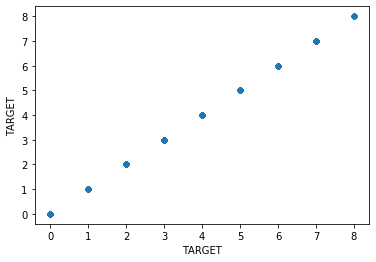

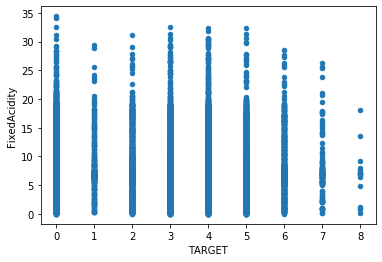

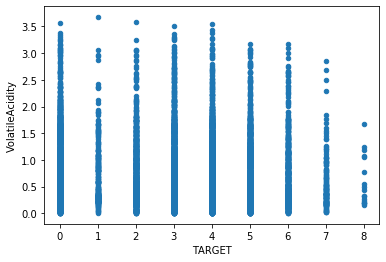

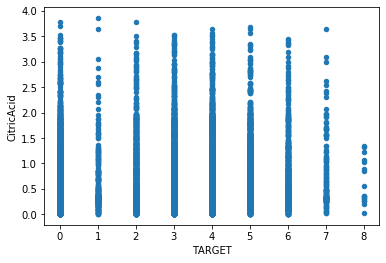

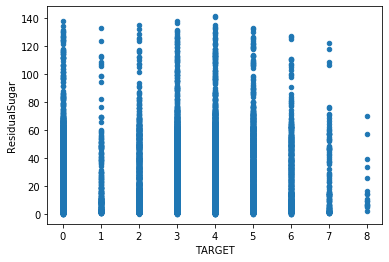

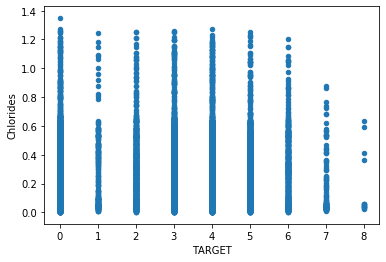

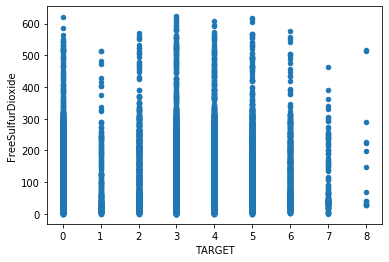

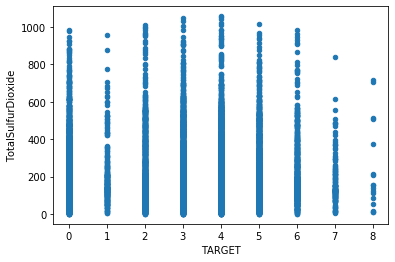

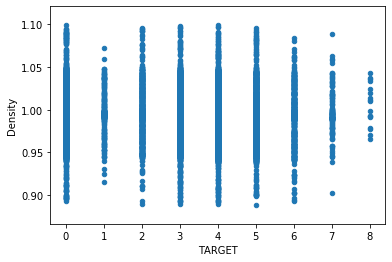

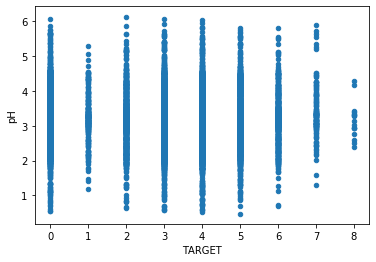

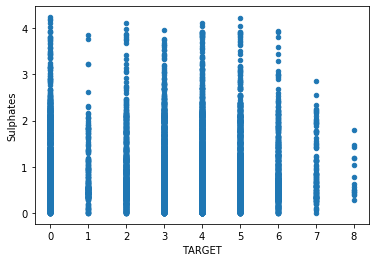

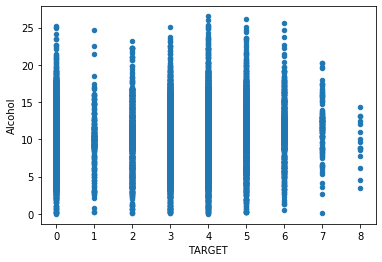

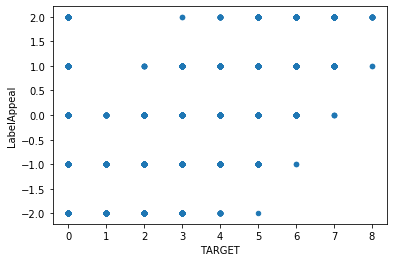

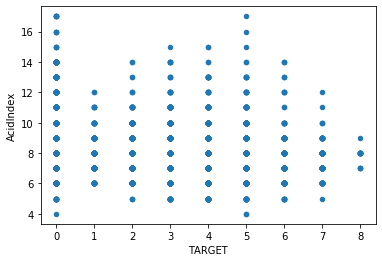

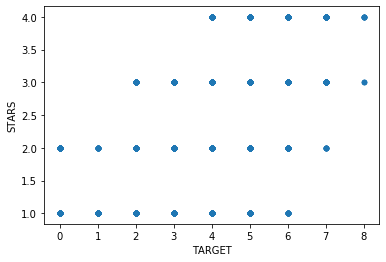

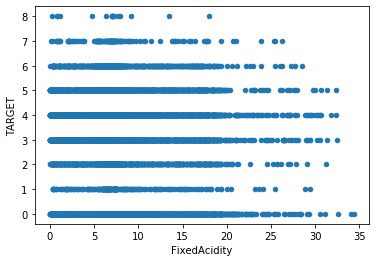

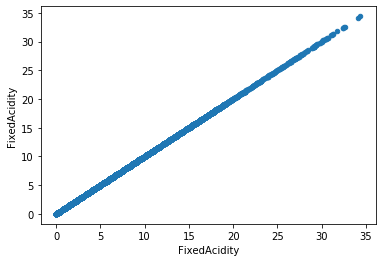

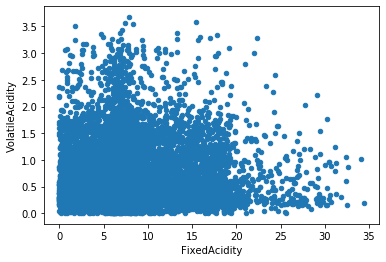

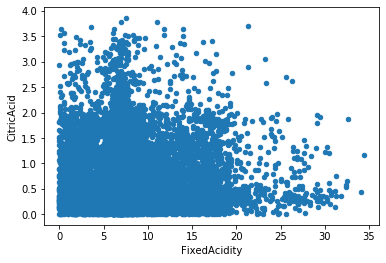

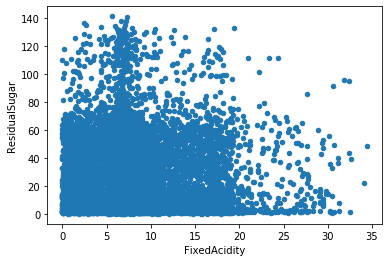

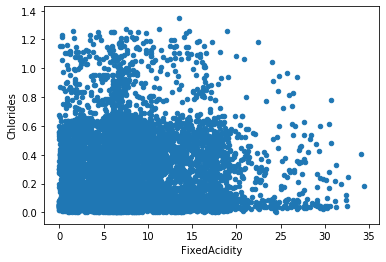

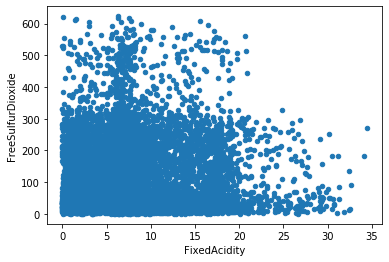

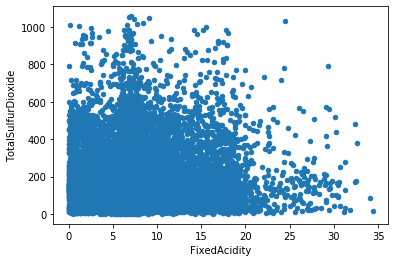

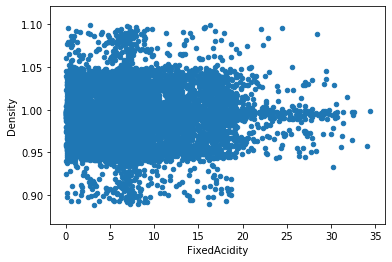

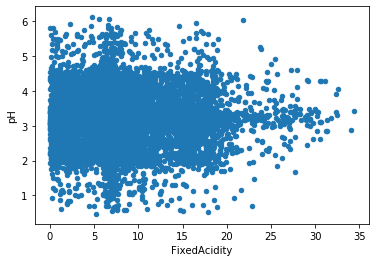

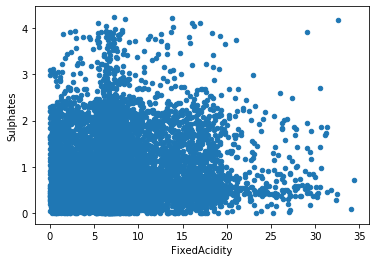

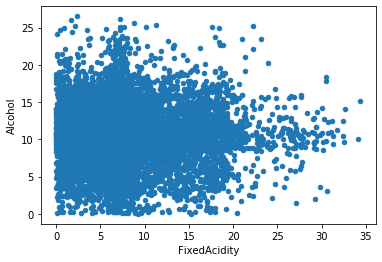

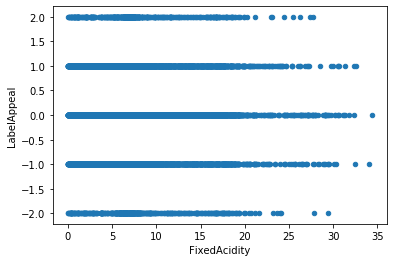

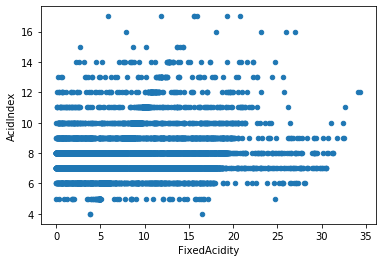

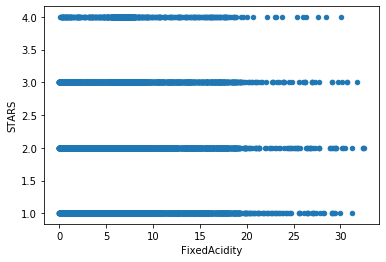

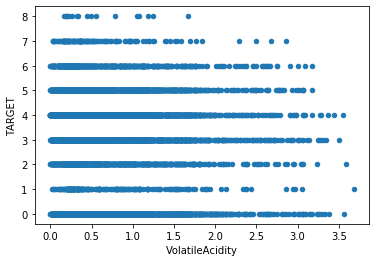

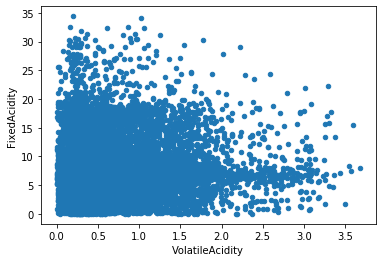

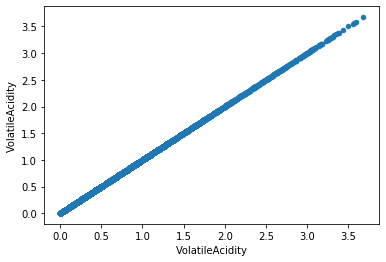

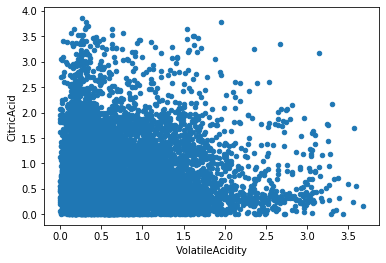

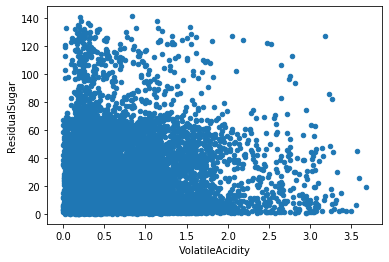

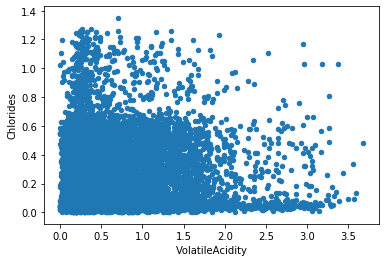

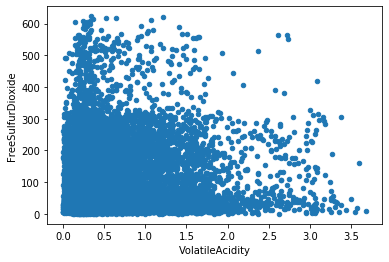

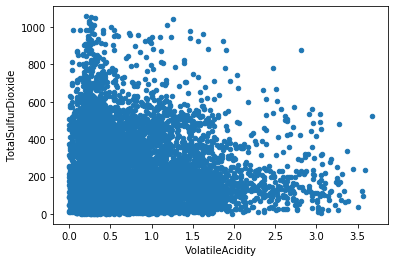

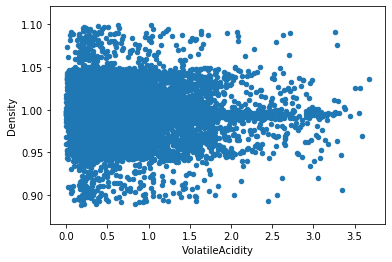

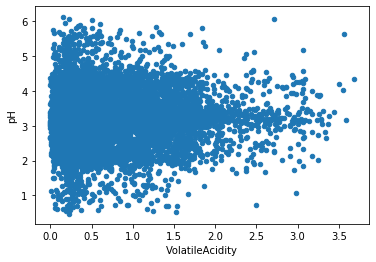

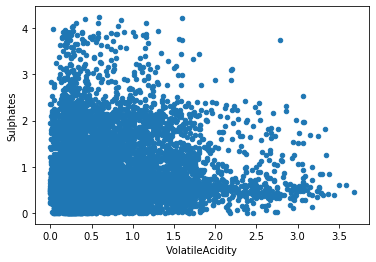

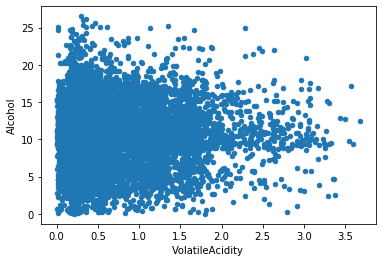

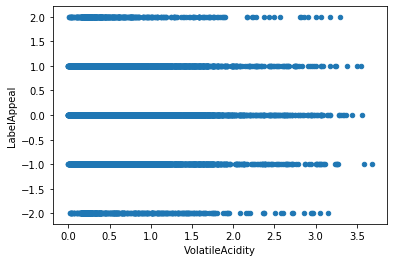

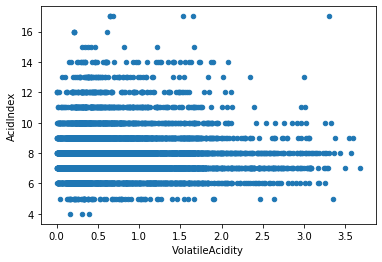

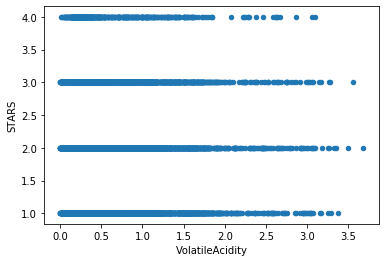

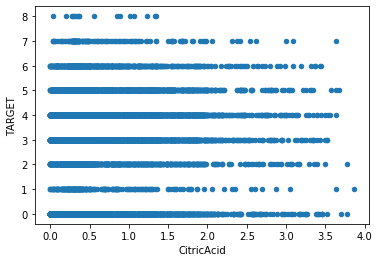

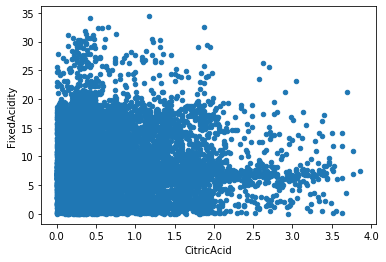

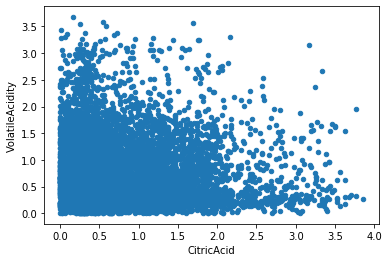

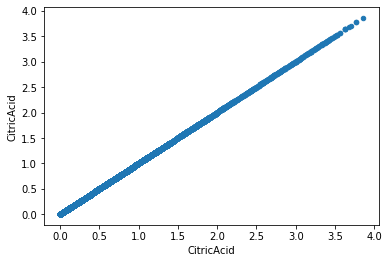

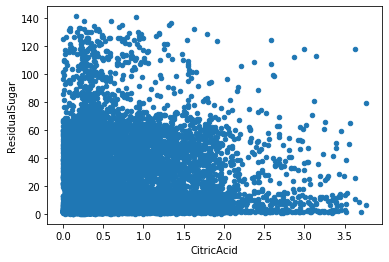

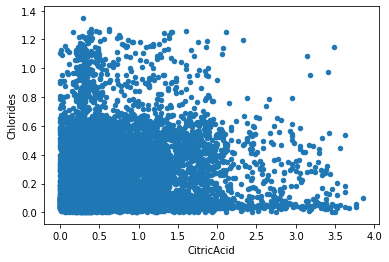

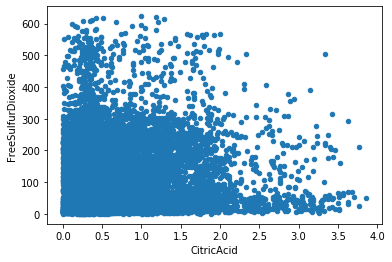

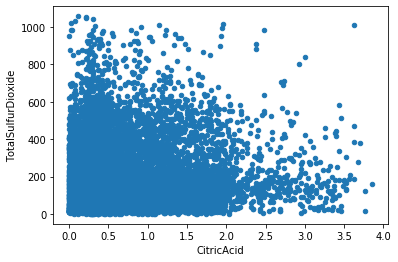

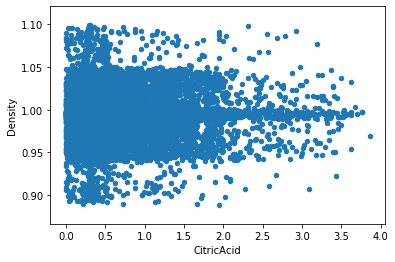

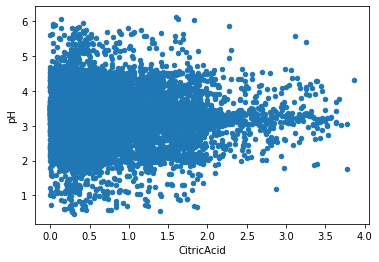

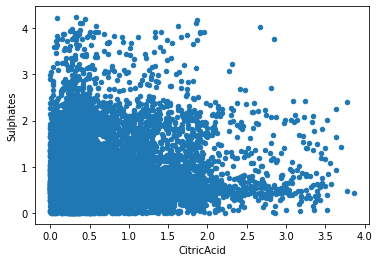

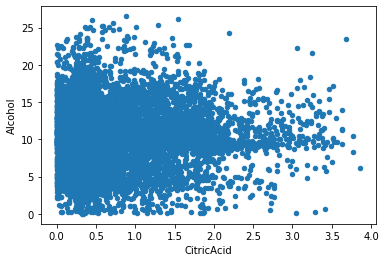

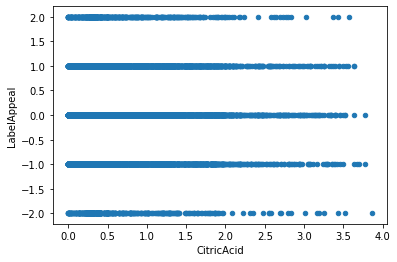

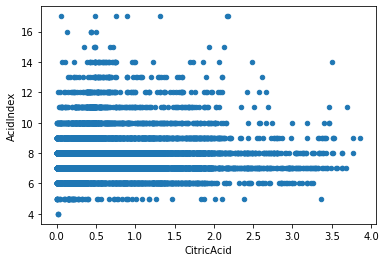

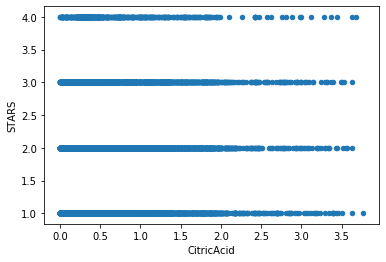

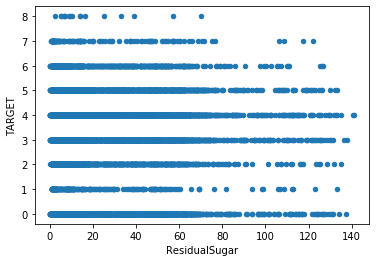

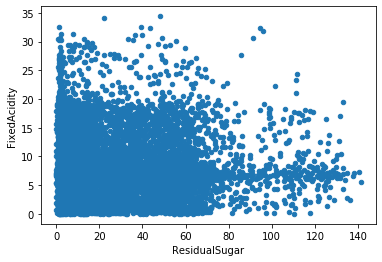

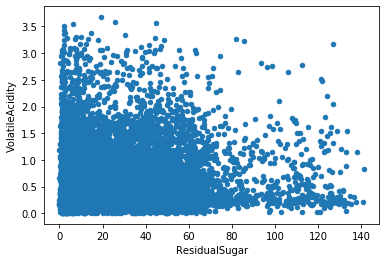

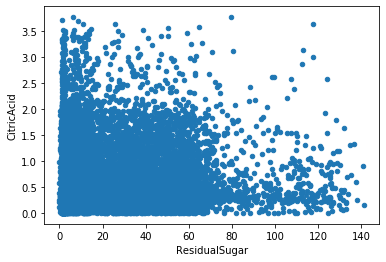

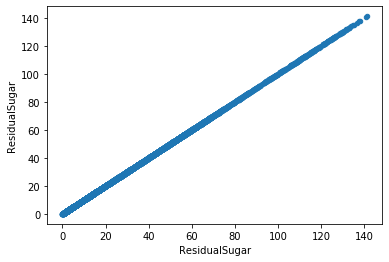

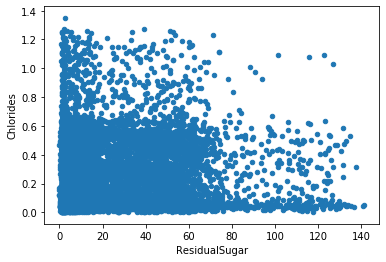

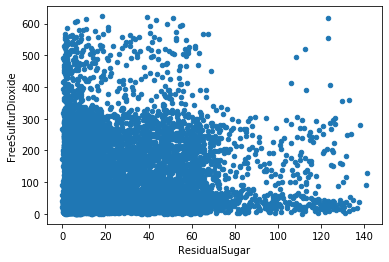

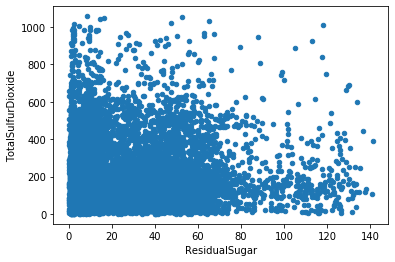

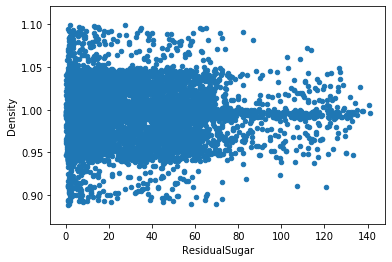

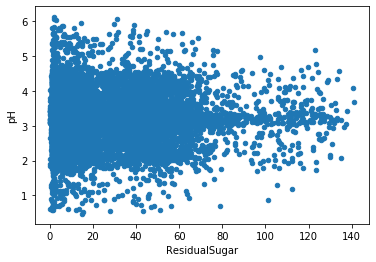

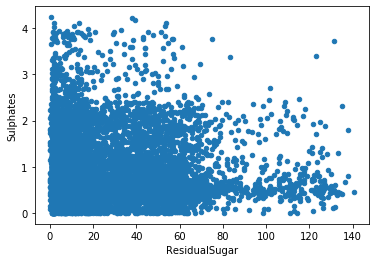

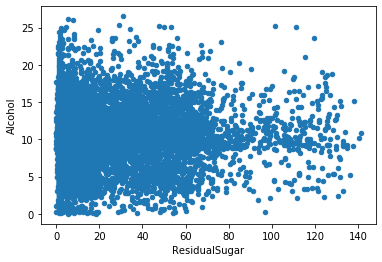

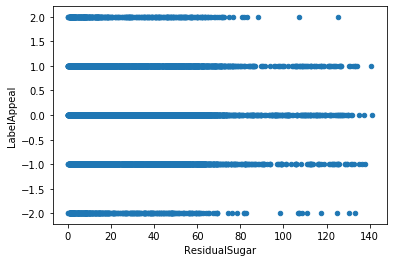

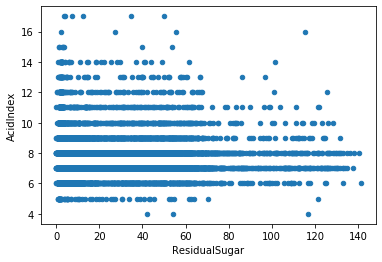

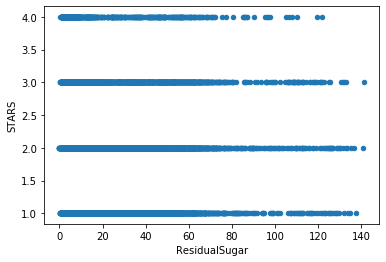

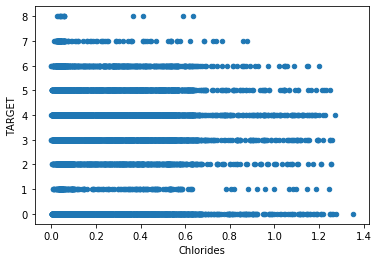

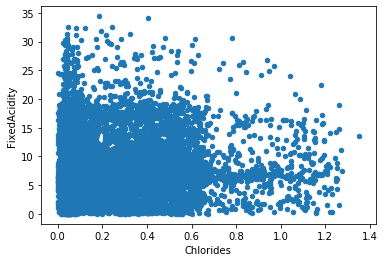

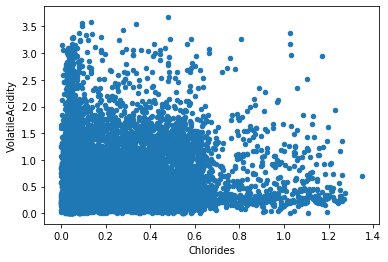

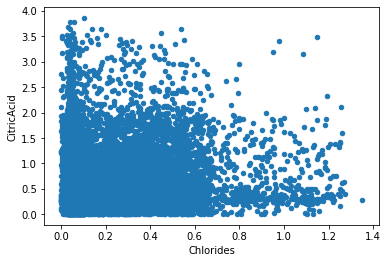

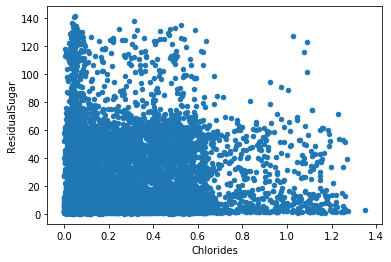

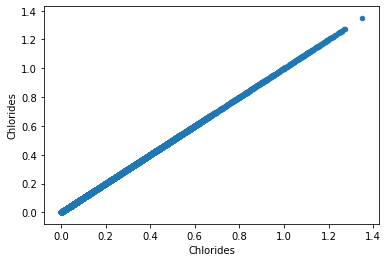

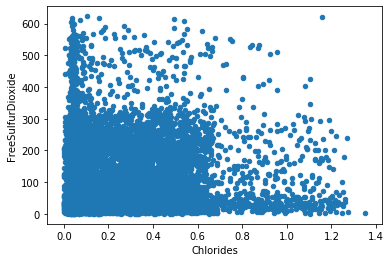

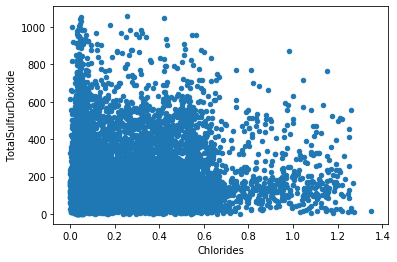

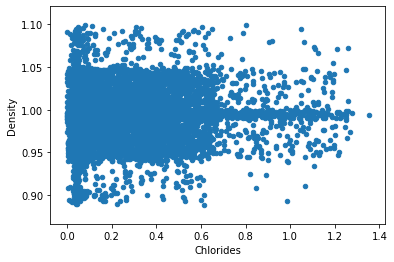

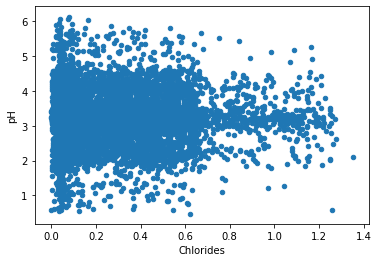

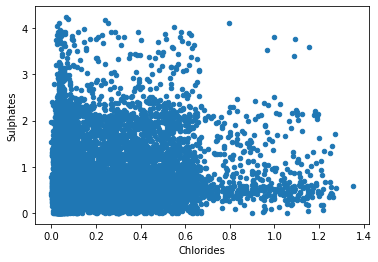

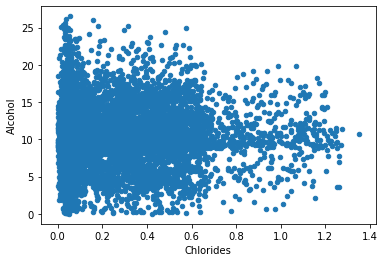

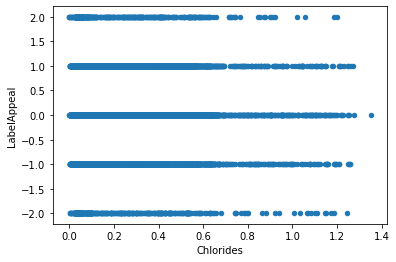

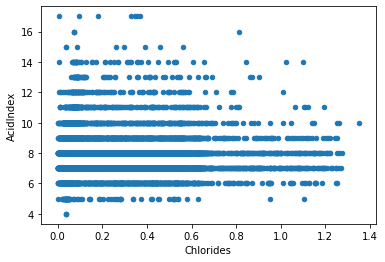

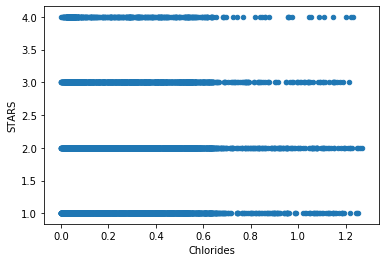

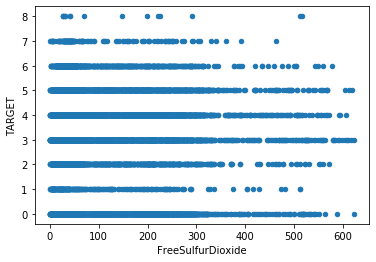

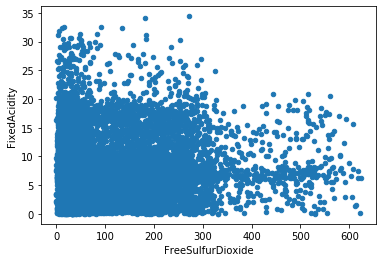

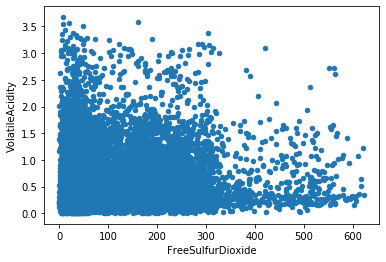

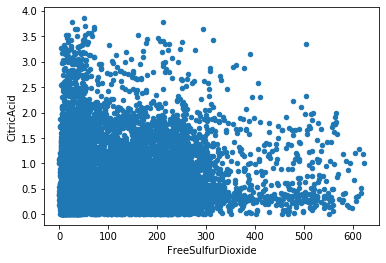

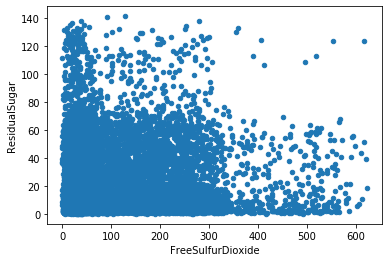

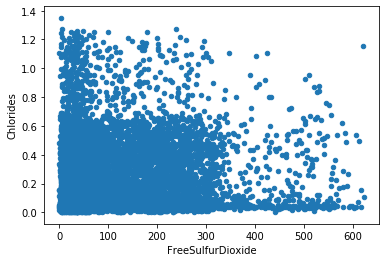

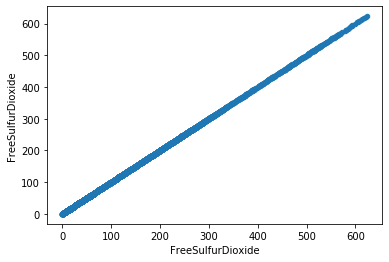

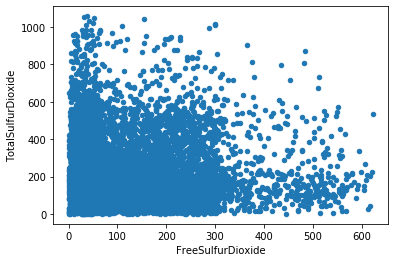

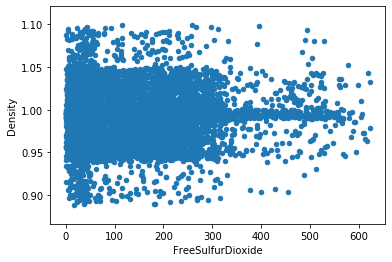

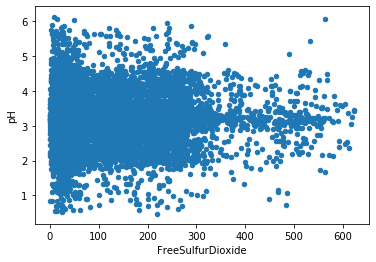

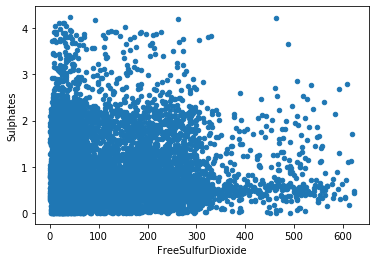

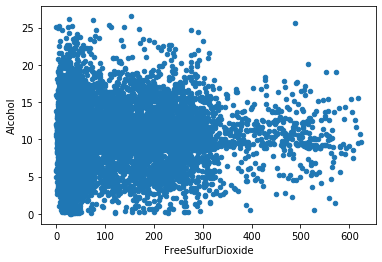

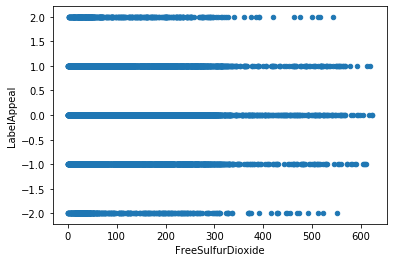

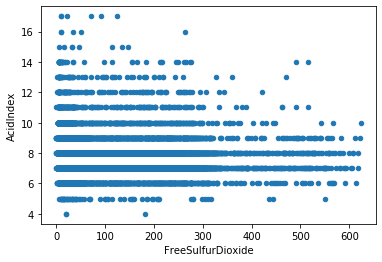

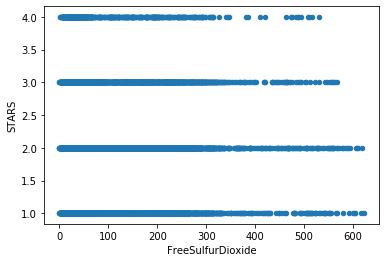

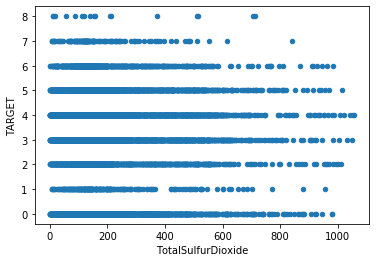

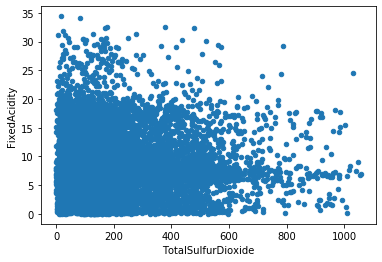

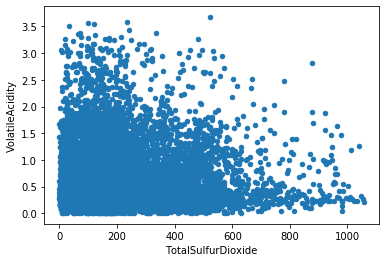

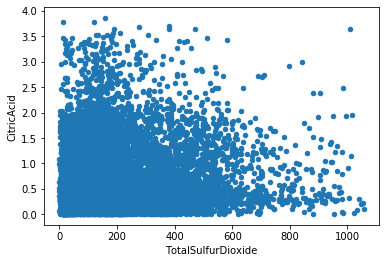

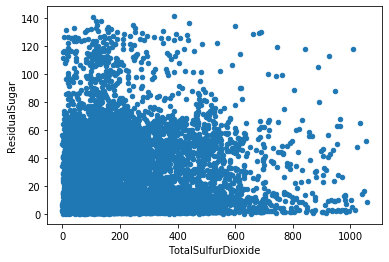

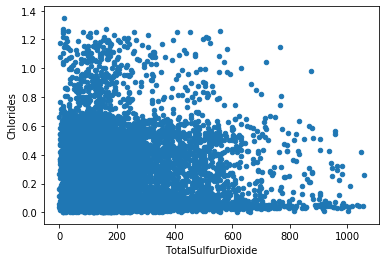

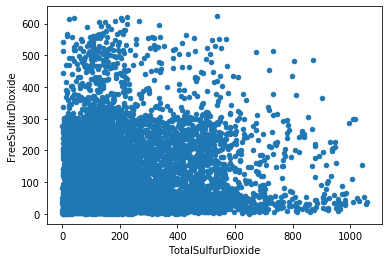

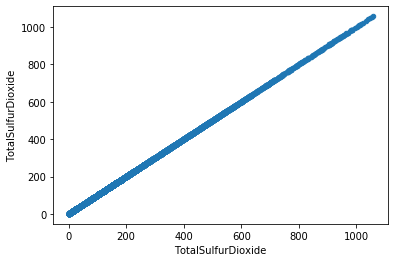

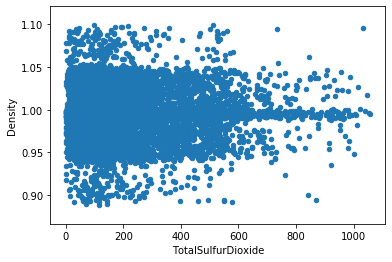

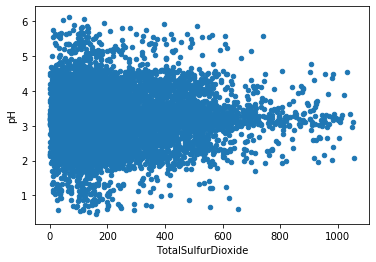

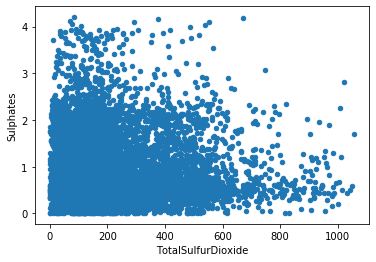

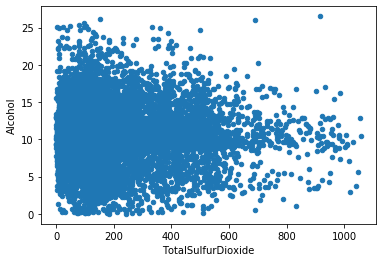

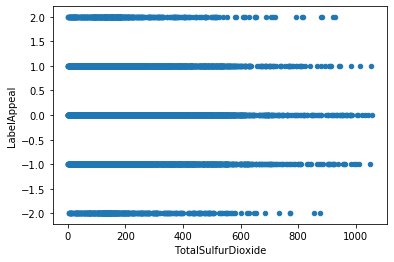

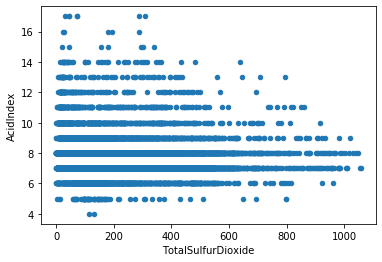

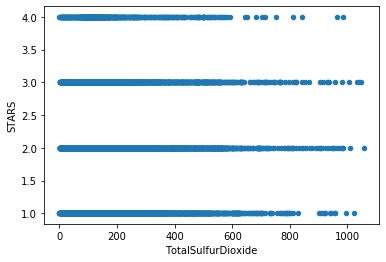

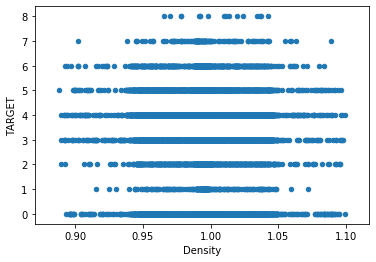

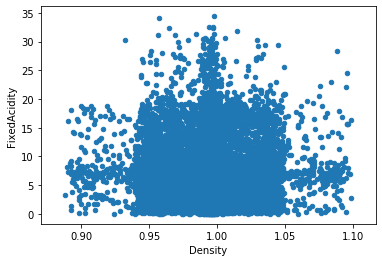

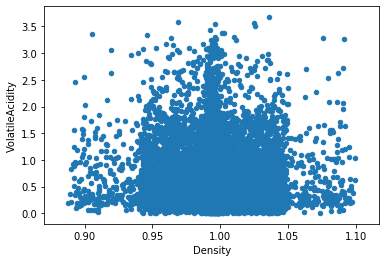

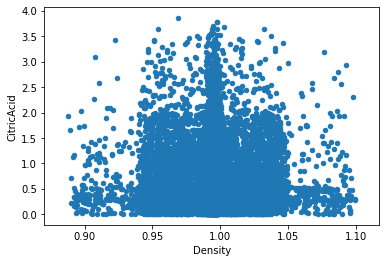

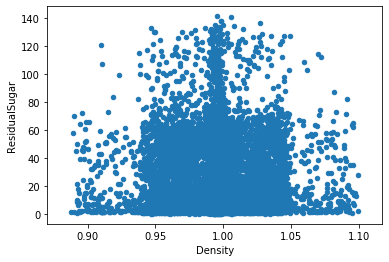

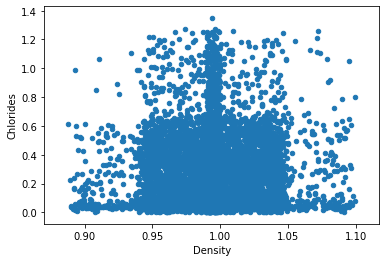

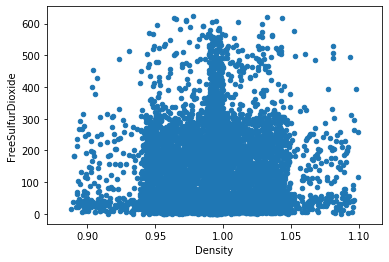

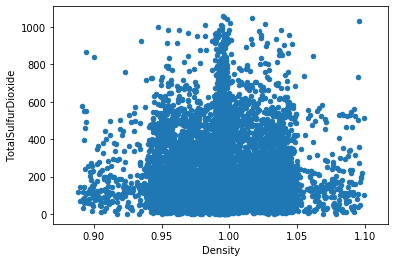

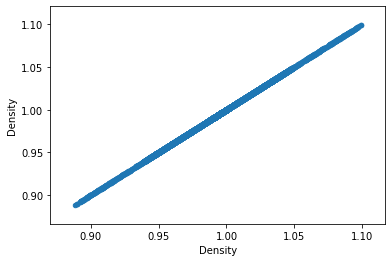

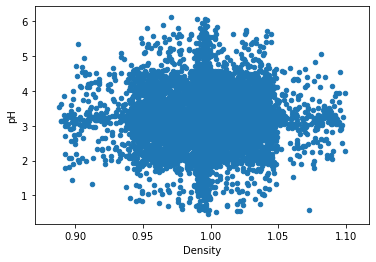

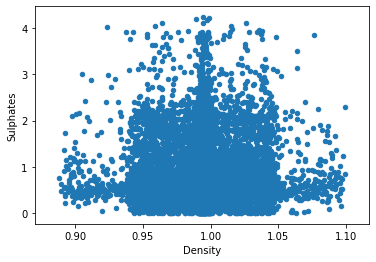

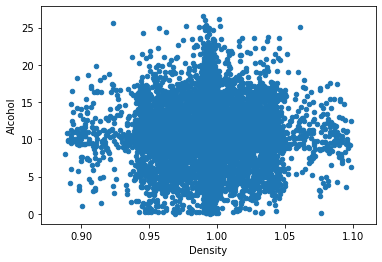

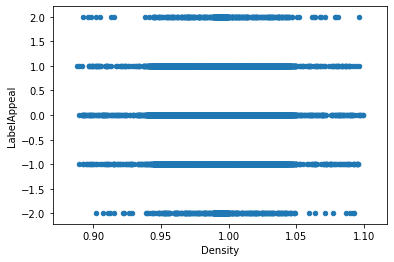

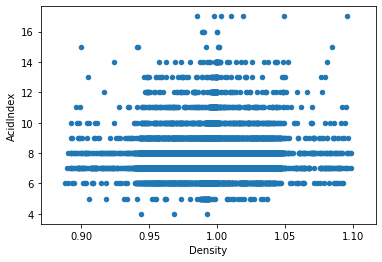

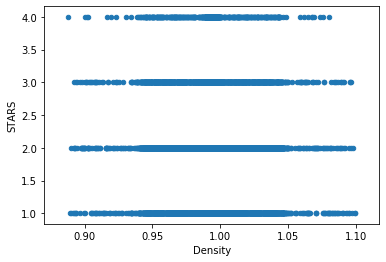

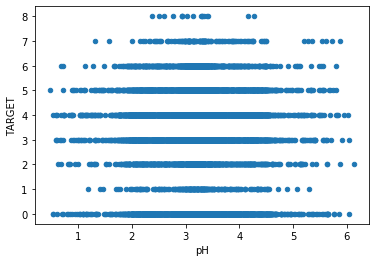

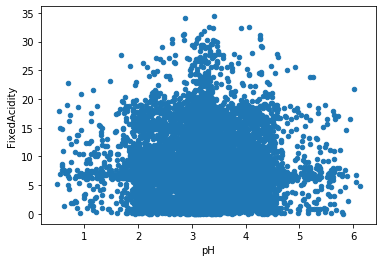

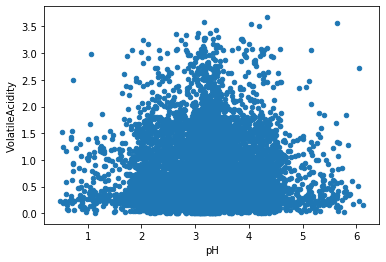

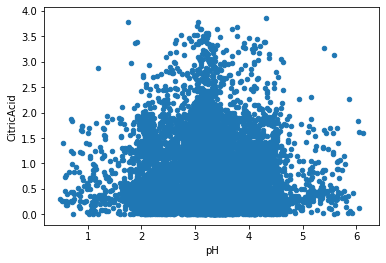

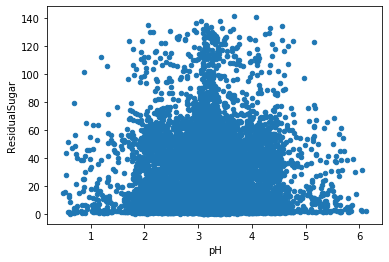

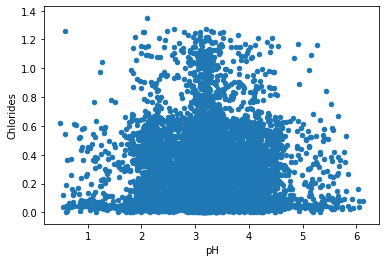

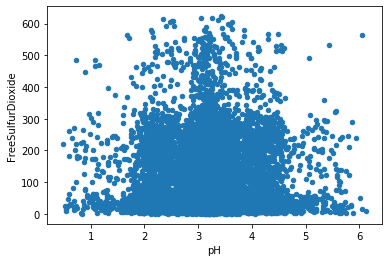

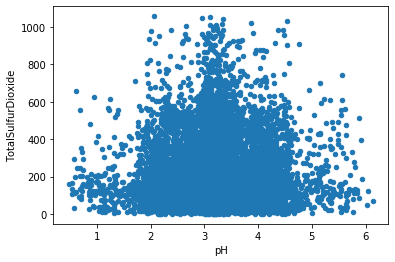

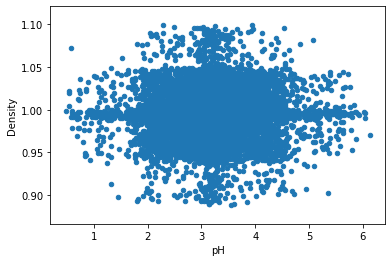

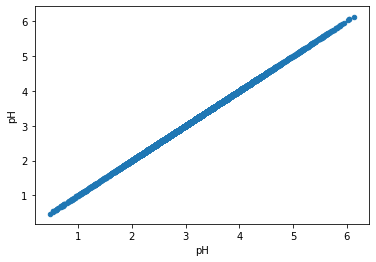

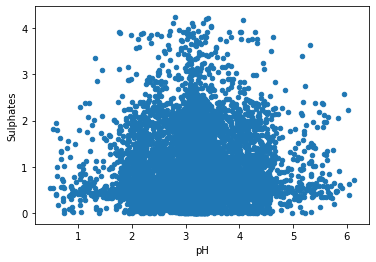

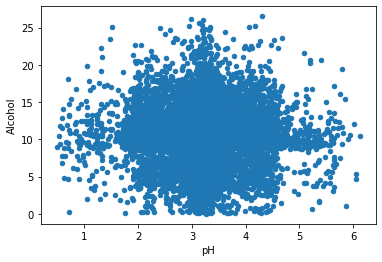

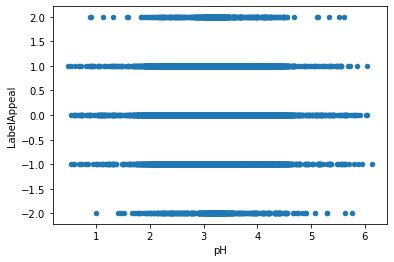

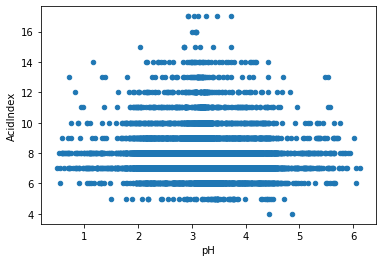

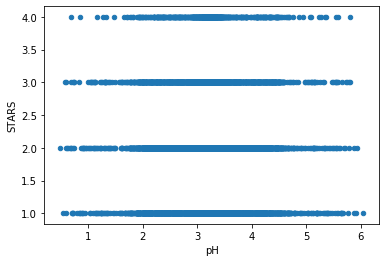

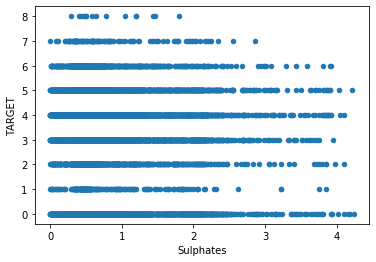

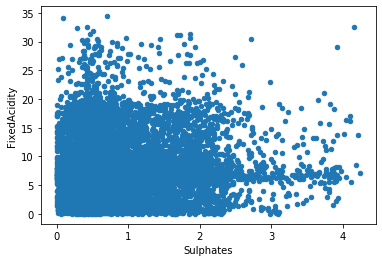

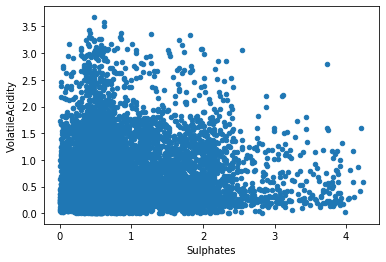

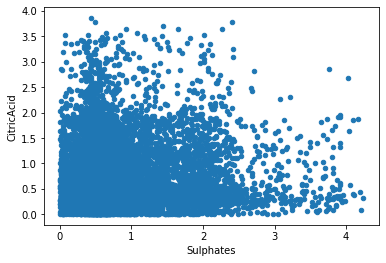

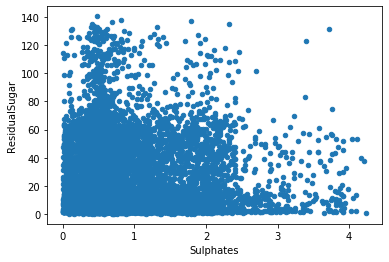

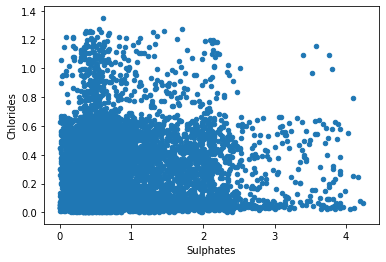

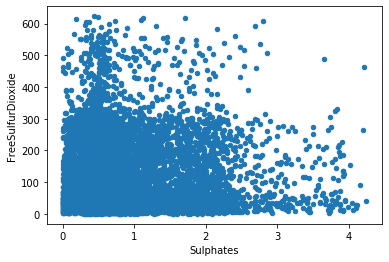

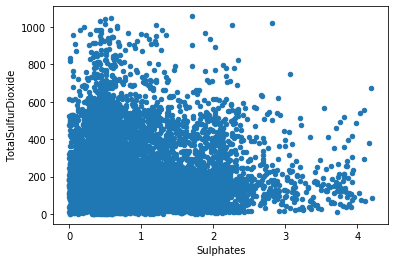

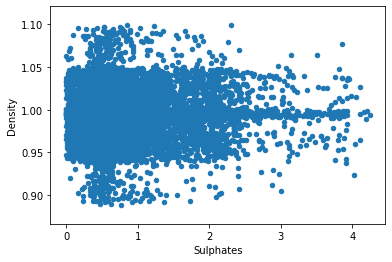

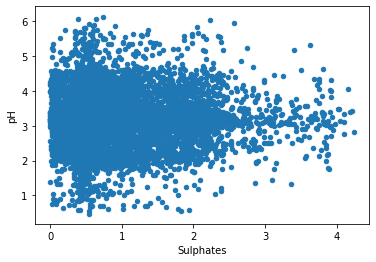

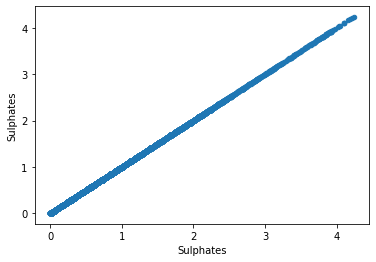

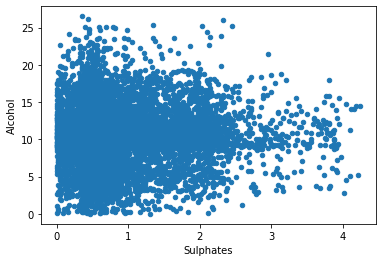

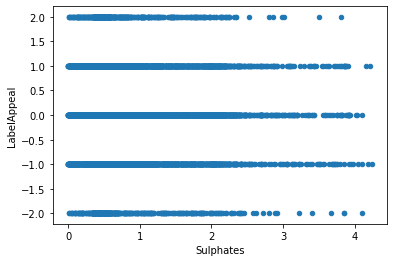

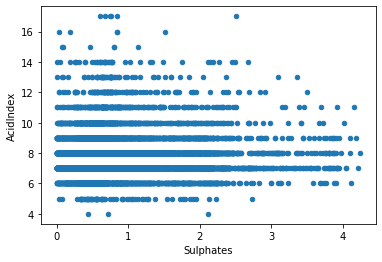

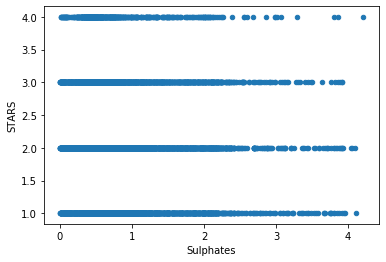

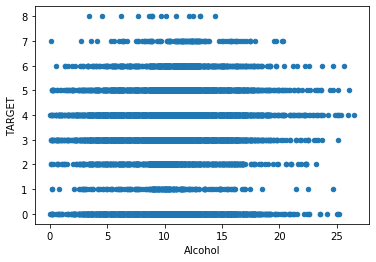

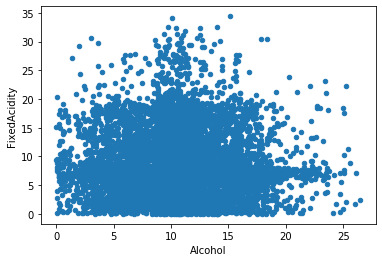

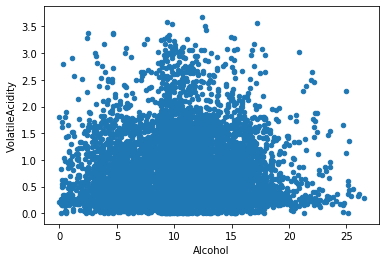

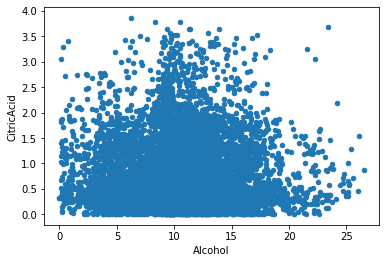

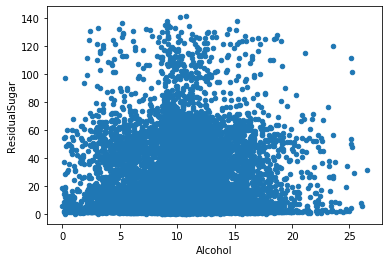

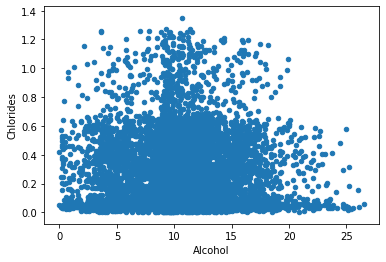

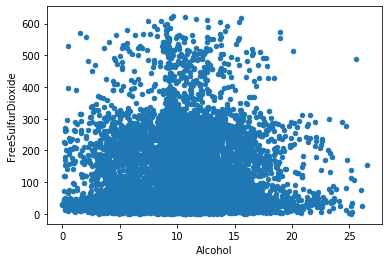

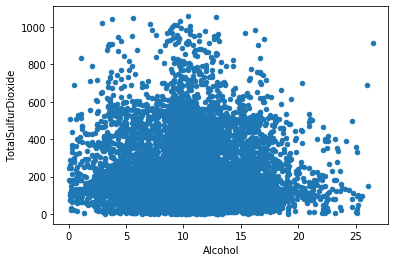

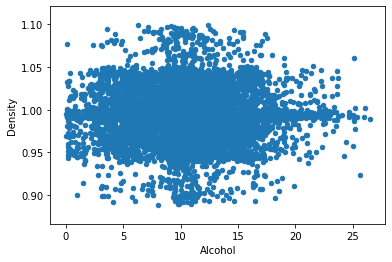

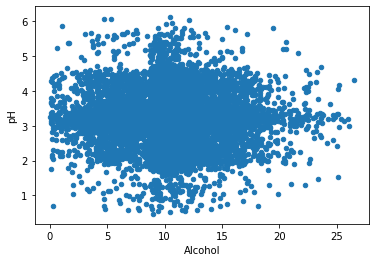

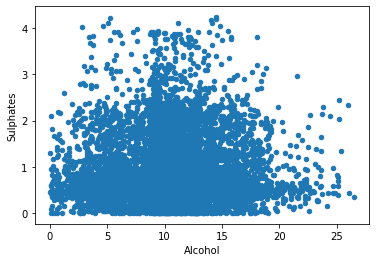

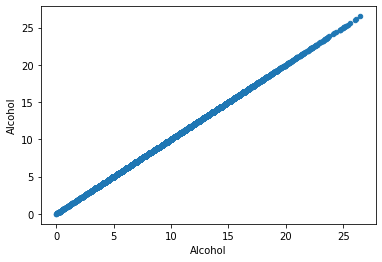

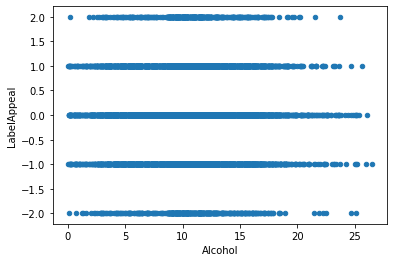

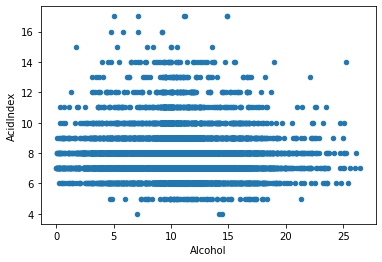

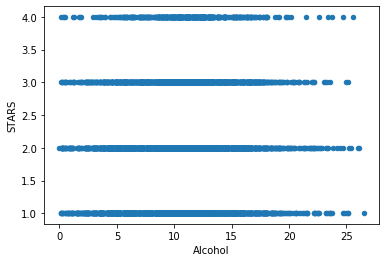

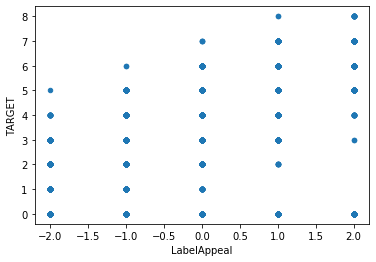

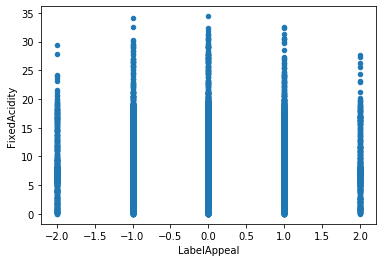

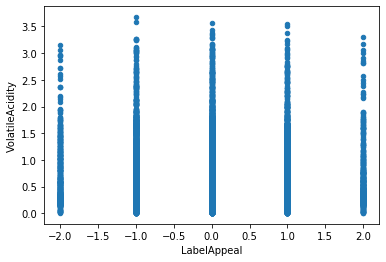

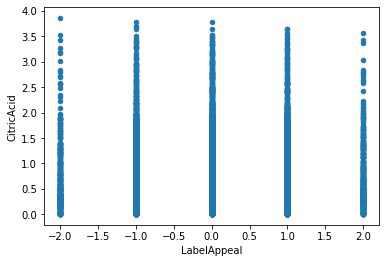

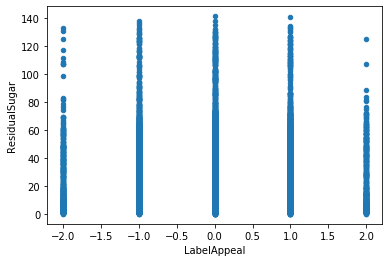

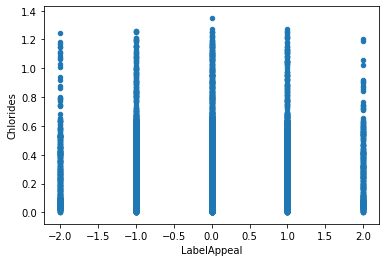

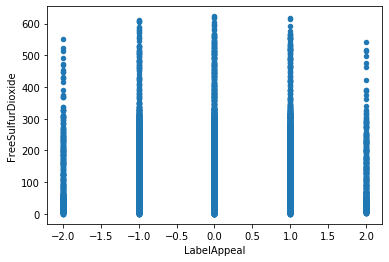

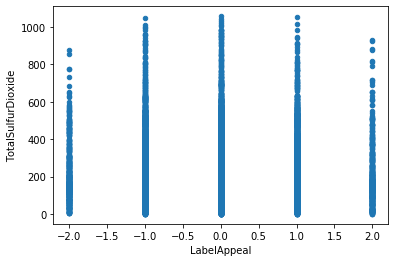

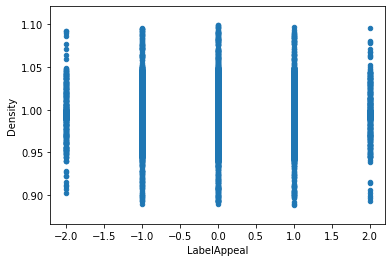

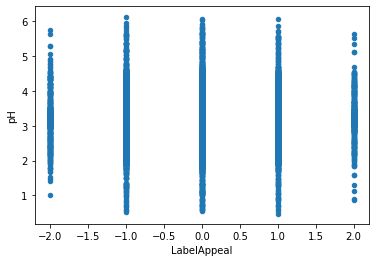

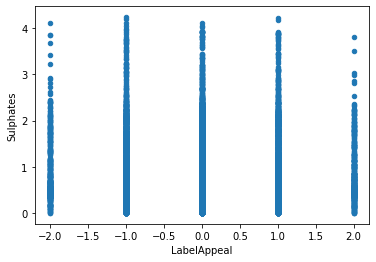

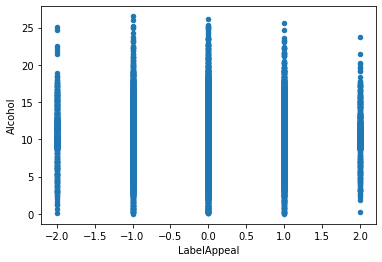

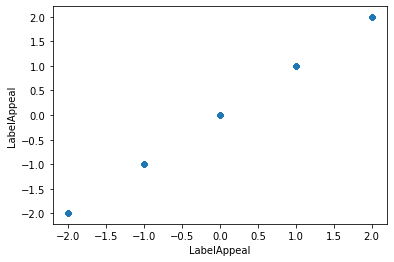

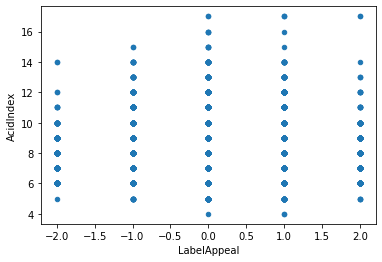

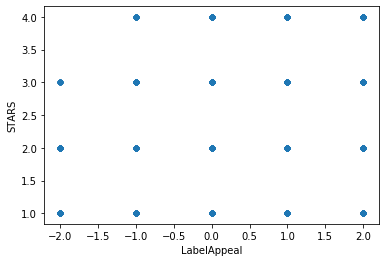

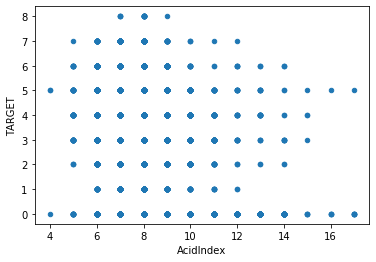

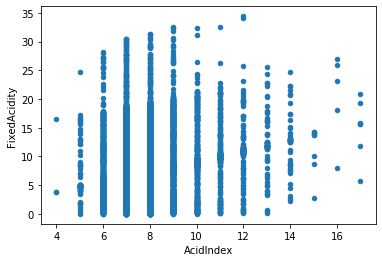

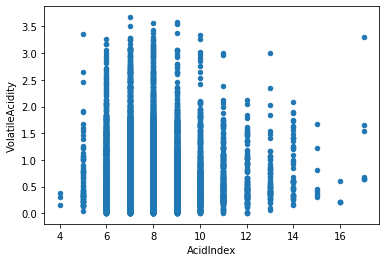

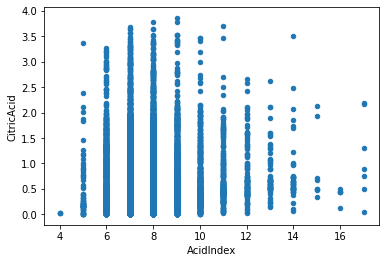

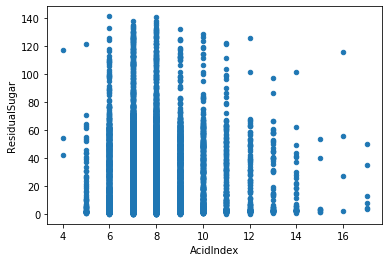

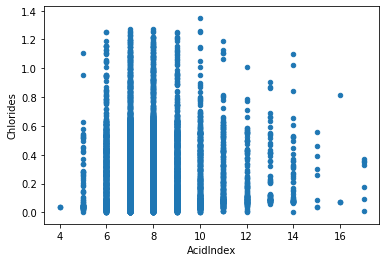

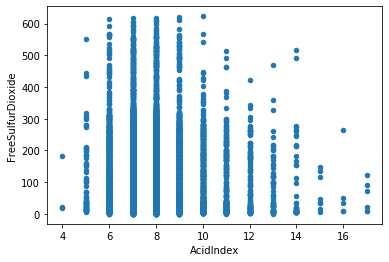

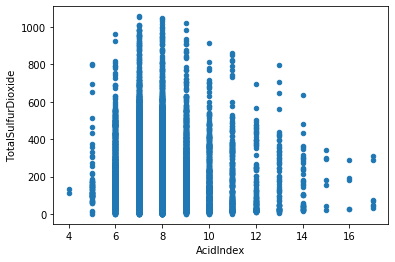

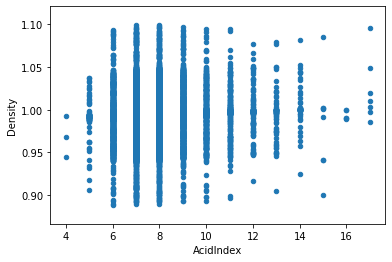

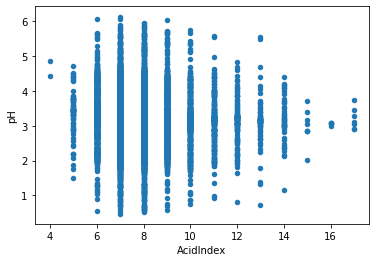

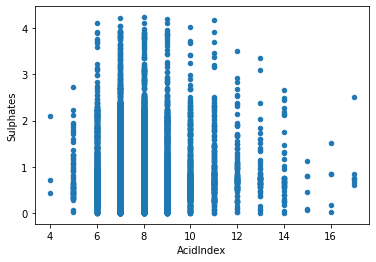

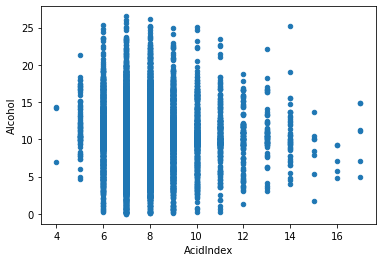

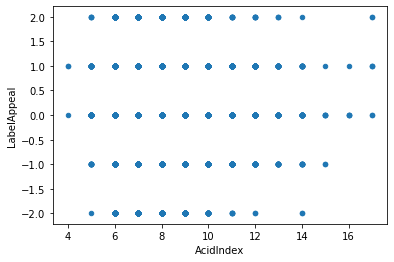

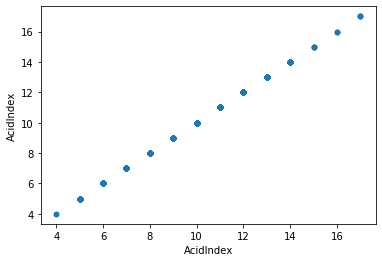

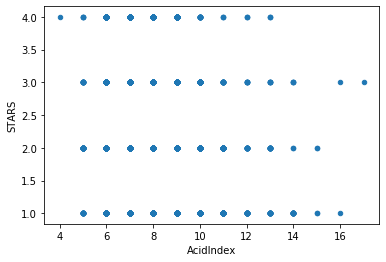

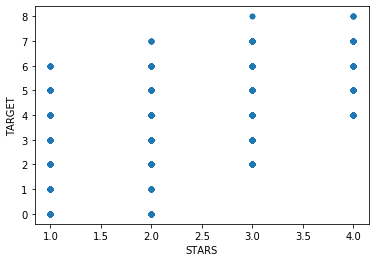

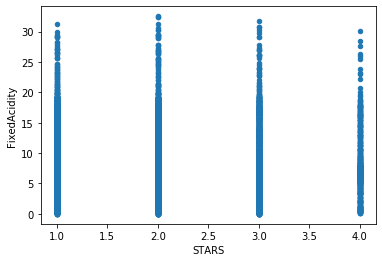

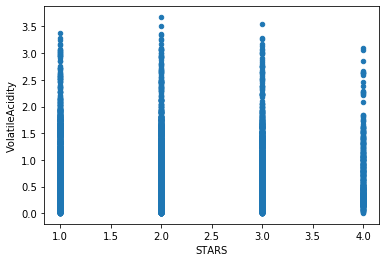

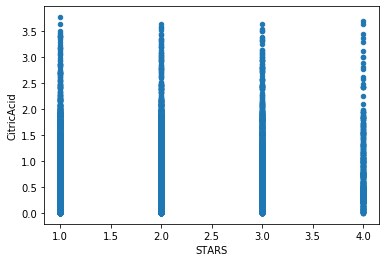

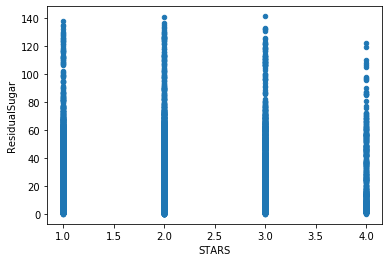

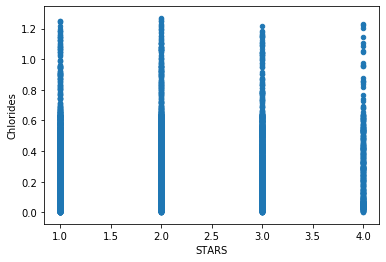

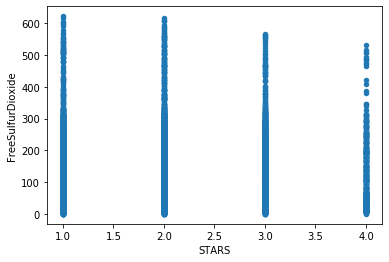

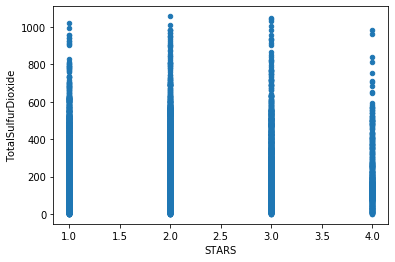

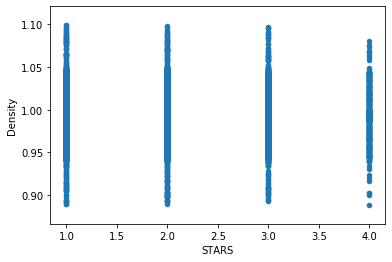

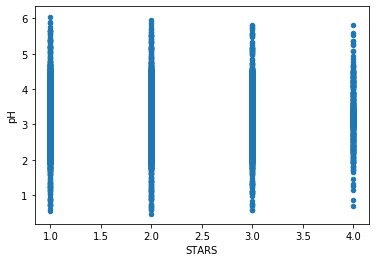

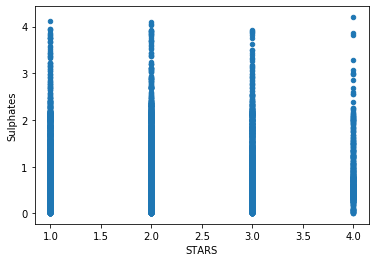

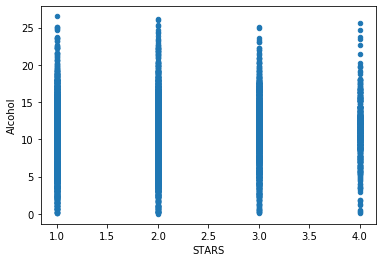

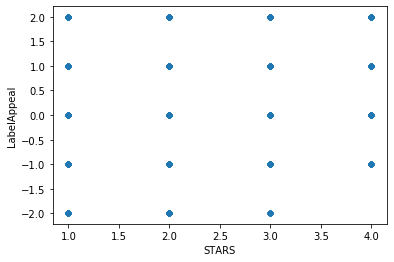

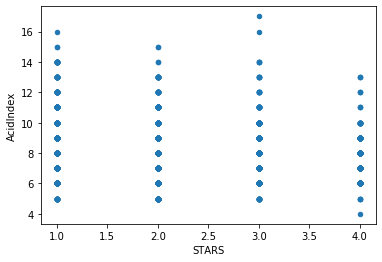

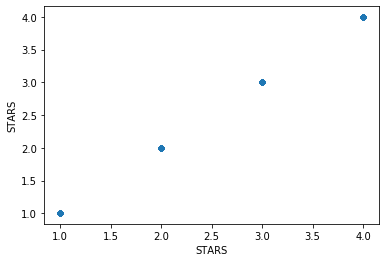

In [9]:
#scatterplot for outlier of the wine dataset
for x in df.columns[:]:
    for y in df.columns[:]:
        df.plot.scatter(x=x, y=y)
        plt.show()

In [10]:
#treating missing values
cols=['FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
       'Density', 'pH', 'Sulphates', 'Alcohol','AcidIndex']
df_chem=df[cols]
df_chem.head() #df_chem contains only the chemical properties of the wine to start with

FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
0           3.2            1.160        0.98           54.2      0.567   
1           4.5            0.160        0.81           26.1      0.425   
2           7.1            2.640        0.88           14.8      0.037   
3           5.7            0.385        0.04           18.8      0.425   
4           8.0            0.330        1.26            9.4        NaN   

   FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  Alcohol  \
0                NaN               268.0  0.99280  3.33       0.59      9.9   
1               15.0               327.0  1.02792  3.38       0.70      NaN   
2              214.0               142.0  0.99518  3.12       0.48     22.0   
3               22.0               115.0  0.99640  2.24       1.83      6.2   
4              167.0               108.0  0.99457  3.12       1.77     13.7   

   AcidIndex  
0          8  
1          7  
2          8  
3          6  
4          9

In [11]:
#imputing values for chem properties
imputer = KNNImputer(n_neighbors=2)  #impute missing values
df_chem=pd.DataFrame(imputer.fit_transform(df_chem),columns=df_chem.columns)

In [12]:
df_chem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12795 entries, 0 to 12794
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FixedAcidity        12795 non-null  float64
 1   VolatileAcidity     12795 non-null  float64
 2   CitricAcid          12795 non-null  float64
 3   ResidualSugar       12795 non-null  float64
 4   Chlorides           12795 non-null  float64
 5   FreeSulfurDioxide   12795 non-null  float64
 6   TotalSulfurDioxide  12795 non-null  float64
 7   Density             12795 non-null  float64
 8   pH                  12795 non-null  float64
 9   Sulphates           12795 non-null  float64
 10  Alcohol             12795 non-null  float64
 11  AcidIndex           12795 non-null  float64
dtypes: float64(12)
memory usage: 1.2 MB


In [13]:
df = df.assign(**{c: df_chem[c].to_numpy() for c in ('FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
       'Density', 'pH', 'Sulphates', 'Alcohol','AcidIndex')})

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12795 entries, 0 to 12794
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET              12795 non-null  int64  
 1   FixedAcidity        12795 non-null  float64
 2   VolatileAcidity     12795 non-null  float64
 3   CitricAcid          12795 non-null  float64
 4   ResidualSugar       12795 non-null  float64
 5   Chlorides           12795 non-null  float64
 6   FreeSulfurDioxide   12795 non-null  float64
 7   TotalSulfurDioxide  12795 non-null  float64
 8   Density             12795 non-null  float64
 9   pH                  12795 non-null  float64
 10  Sulphates           12795 non-null  float64
 11  Alcohol             12795 non-null  float64
 12  LabelAppeal         12795 non-null  int64  
 13  AcidIndex           12795 non-null  float64
 14  STARS               9436 non-null   float64
dtypes: float64(13), int64(2)
memory usage: 1.5 MB


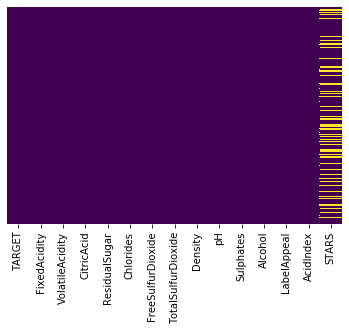

In [15]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis') #imputed all missing values

In [17]:
#columns of interest to predict the classification of STARS
cols = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
       'Density', 'pH', 'Sulphates', 'Alcohol', 'LabelAppeal', 'AcidIndex']

In [18]:
#taking the data where we dont have values for STARS
df_starsNull = df[df['STARS'].isnull()]
df_starsNull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3359 entries, 5 to 12790
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET              3359 non-null   int64  
 1   FixedAcidity        3359 non-null   float64
 2   VolatileAcidity     3359 non-null   float64
 3   CitricAcid          3359 non-null   float64
 4   ResidualSugar       3359 non-null   float64
 5   Chlorides           3359 non-null   float64
 6   FreeSulfurDioxide   3359 non-null   float64
 7   TotalSulfurDioxide  3359 non-null   float64
 8   Density             3359 non-null   float64
 9   pH                  3359 non-null   float64
 10  Sulphates           3359 non-null   float64
 11  Alcohol             3359 non-null   float64
 12  LabelAppeal         3359 non-null   int64  
 13  AcidIndex           3359 non-null   float64
 14  STARS               0 non-null      float64
dtypes: float64(13), int64(2)
memory usage: 419.9 KB


In [20]:
#taking the data where we have values for STARS
df_starsNotnull = df[df['STARS'].notnull()]
df_starsNotnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9436 entries, 0 to 12794
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET              9436 non-null   int64  
 1   FixedAcidity        9436 non-null   float64
 2   VolatileAcidity     9436 non-null   float64
 3   CitricAcid          9436 non-null   float64
 4   ResidualSugar       9436 non-null   float64
 5   Chlorides           9436 non-null   float64
 6   FreeSulfurDioxide   9436 non-null   float64
 7   TotalSulfurDioxide  9436 non-null   float64
 8   Density             9436 non-null   float64
 9   pH                  9436 non-null   float64
 10  Sulphates           9436 non-null   float64
 11  Alcohol             9436 non-null   float64
 12  LabelAppeal         9436 non-null   int64  
 13  AcidIndex           9436 non-null   float64
 14  STARS               9436 non-null   float64
dtypes: float64(13), int64(2)
memory usage: 1.2 MB


In [22]:
y= df_starsNotnull['STARS']  #assigning the response variable

In [23]:
#splitting the df_starsNotnull dataset into a training set (60%) and a validiation set (40%).
train_X, valid_X, train_y, valid_y = train_test_split(df_starsNotnull, y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (5661, 15) Validation set: (3775, 15)


In [24]:
train_X1 = train_X[cols] #taking only the columns of interest cols
valid_X1 = valid_X[cols] #taking only the columns of interest cols

In [25]:
#scaling the training dataset
scaler = preprocessing.MinMaxScaler()
scaler.fit(train_X1.iloc[:,:-1])
train_X1_scaled=pd.DataFrame(scaler.transform(train_X1.iloc[:,:-1]), columns=train_X1.columns[:-1])
valid_X1_scaled=pd.DataFrame(scaler.transform(valid_X1.iloc[:,:-1]), columns=valid_X1.columns[:-1])

In [26]:
train_X1_scaled #scaled training dataset (made from df_starsNotnull)

FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
0         0.820988         0.057143    0.196286       0.357775   0.477218   
1         0.472222         0.788571    0.546419       0.338647   0.034373   
2         0.277778         0.114286    0.108753       0.014169   0.003197   
3         0.070988         0.045714    0.456233       0.009919   0.545963   
4         0.188272         0.071429    0.127321       0.040383   0.180655   
...            ...              ...         ...            ...        ...   
5656      0.172840         0.080000    0.262599       0.007085   0.463629   
5657      0.163580         0.514286    0.190981       0.138151   0.023181   
5658      0.219136         0.041429    0.225464       0.327311   0.237410   
5659      0.191358         0.002857    0.549072       0.007793   0.031974   
5660      0.222222         0.062857    0.183024       0.304640   0.430056   

      FreeSulfurDioxide  TotalSulfurDioxide   Density        pH  Sulphates  \
0              0.406752            0.154210  0.493268  0.537313   0.375297   
1              0.045016            0.025544  0.519908  0.494403   0.326603   
2              0.004823            0.207190  0.337964  0.492537   0.296912   
3              0.162379            0.104068  0.493746  0.494403   0.087886   
4              0.040193            0.070956  0.665712  0.464552   0.078385   
...                 ...                 ...       ...       ...        ...   
5656           0.009646            0.291391  0.479423  0.733209   0.080760   
5657           0.009646            0.207190  0.336293  0.531716   0.114014   
5658           0.223473            0.074740  0.460518  0.477612   0.209026   
5659           0.061093            0.175024  0.529218  0.436567   0.099762   
5660           0.054662            0.132450  0.478468  0.460821   0.104513   

       Alcohol  LabelAppeal  
0     0.384906         0.50  
1     0.535849         0.75  
2     0.271698         0.50  
3     0.335849         0.25  
4     0.347170         0.25  
...        ...          ...  
5656  0.430189         0.00  
5657  0.449057         0.75  
5658  0.584906         0.25  
5659  0.516981         0.50  
5660  0.479245         0.50  

[5661 rows x 12 columns]

In [27]:
#scaling the validation dataset
#scaler = preprocessing.MinMaxScaler()
#scaler.fit(valid_X1.iloc[:,:-1])
valid_X1_scaled=pd.DataFrame(scaler.transform(valid_X1.iloc[:,:-1]), columns=valid_X1.columns[:-1])

In [28]:
valid_X1_scaled #scaled validation dataset (made from df_starsNotnull)

FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
0         0.345679         0.108571    0.023873       0.174283   0.465228   
1         0.290123         0.302857    0.456233       0.263549   0.165468   
2         0.262346         0.182857    0.021220       0.097060   0.034373   
3         0.145062         0.142857    0.076923       0.161530   0.035172   
4         0.101852         0.657143    0.063660       0.300390   0.035172   
...            ...              ...         ...            ...        ...   
3770      0.441358         0.282857    0.039788       0.008502   0.042366   
3771      0.064815         0.060000    0.209549       0.097414   0.502798   
3772      0.271605         0.554286    0.122016       0.033298   0.031974   
3773      0.237654         0.114286    0.015915       0.277010   0.027178   
3774      0.509259         0.072857    0.259947       0.212540   0.029576   

      FreeSulfurDioxide  TotalSulfurDioxide   Density        pH  Sulphates  \
0              0.395498            0.162725  0.619975  0.432836   0.087886   
1              0.130225            0.148534  0.491836  0.444030   0.128266   
2              0.041801            0.118259  0.512843  0.761194   0.510689   
3              0.252412            0.092715  0.510312  0.356343   0.085511   
4              0.088424            0.143803  0.378449  0.509328   0.090261   
...                 ...                 ...       ...       ...        ...   
3770           0.098071            0.542100  0.698129  0.611940   0.102138   
3771           0.041801            0.333018  0.667431  0.509328   0.122328   
3772           0.226688            0.114475  0.689678  0.486940   0.114014   
3773           0.490354            0.147588  0.134107  0.684701   0.140143   
3774           0.168810            0.122990  0.513559  0.567164   0.149644   

       Alcohol  LabelAppeal  
0     0.422642         0.50  
1     0.147170         0.25  
2     0.335849         0.75  
3     0.683019         0.25  
4     0.520755         0.75  
...        ...          ...  
3770  0.347170         0.25  
3771  0.430189         0.50  
3772  0.456604         0.50  
3773  0.328302         0.25  
3774  0.535849         0.75  

[3775 rows x 12 columns]

In [29]:
#Now we will use a test set made from df_starsNull to predict the missing values of STARS

#creating a test dataset using rows with STAR value as NULL
df_starsNull=df_starsNull.drop(columns='STARS')

In [30]:
df_starsNull.reset_index(drop=True, inplace=True)

In [31]:
df_starsNull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3359 entries, 0 to 3358
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET              3359 non-null   int64  
 1   FixedAcidity        3359 non-null   float64
 2   VolatileAcidity     3359 non-null   float64
 3   CitricAcid          3359 non-null   float64
 4   ResidualSugar       3359 non-null   float64
 5   Chlorides           3359 non-null   float64
 6   FreeSulfurDioxide   3359 non-null   float64
 7   TotalSulfurDioxide  3359 non-null   float64
 8   Density             3359 non-null   float64
 9   pH                  3359 non-null   float64
 10  Sulphates           3359 non-null   float64
 11  Alcohol             3359 non-null   float64
 12  LabelAppeal         3359 non-null   int64  
 13  AcidIndex           3359 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 367.5 KB


In [32]:
df_Test = df_starsNull[cols]

In [33]:
df_Test.info() # this test set is made from df_starsNull

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3359 entries, 0 to 3358
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FixedAcidity        3359 non-null   float64
 1   VolatileAcidity     3359 non-null   float64
 2   CitricAcid          3359 non-null   float64
 3   ResidualSugar       3359 non-null   float64
 4   Chlorides           3359 non-null   float64
 5   FreeSulfurDioxide   3359 non-null   float64
 6   TotalSulfurDioxide  3359 non-null   float64
 7   Density             3359 non-null   float64
 8   pH                  3359 non-null   float64
 9   Sulphates           3359 non-null   float64
 10  Alcohol             3359 non-null   float64
 11  LabelAppeal         3359 non-null   int64  
 12  AcidIndex           3359 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 341.3 KB


In [34]:
#scale the df_Test
df_Test_scaled=pd.DataFrame(scaler.transform(df_Test.iloc[:,:-1]), columns=df_Test.columns[:-1])

In [35]:
########### KNN CLASSIFIER ##################

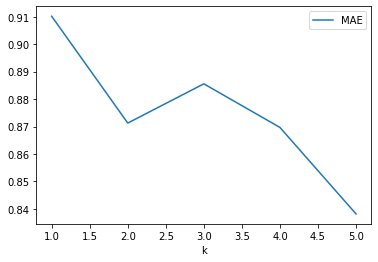

In [37]:
# Train a Classifier for different values of k using train_X1_scaled(made from df_starsNotnull)
results = []
for k in range(1,6):
        knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1).fit(train_X1_scaled, train_y)
        results.append({
            'k': k,
            'MAE': mean_absolute_error(valid_y, knn.predict(valid_X1_scaled))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
results.sort_values(by='MAE')
results.index=results.k
results=results.drop('k',axis=1)
results.plot()

In [38]:
# Train a classifier for different values of k and metric list train_X1_scaled(made from df_starsNotnull)
metric_list=['euclidean','manhattan','chebyshev','minkowski',]
results = []
for k in range(1,6):
    for m in metric_list:
        knn = KNeighborsClassifier(n_neighbors=k,metric=m,n_jobs=-1).fit(train_X1_scaled, train_y)
        results.append({
            'k_distance': str(k)+" "+str(m),
            'MAE': mean_absolute_error(valid_y, knn.predict(valid_X1_scaled))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
results.sort_values(by='MAE')
#results.index=results.k_distance
#results=results.drop('k_distance',axis=1)
#results.plot()

k_distance       MAE
17  5 manhattan  0.832318
19  5 minkowski  0.838146
16  5 euclidean  0.838146
18  5 chebyshev  0.840530
13  4 manhattan  0.852450
14  4 chebyshev  0.853510
5   2 manhattan  0.863046
15  4 minkowski  0.869669
12  4 euclidean  0.869669
6   2 chebyshev  0.870464
4   2 euclidean  0.871258
7   2 minkowski  0.871258
10  3 chebyshev  0.874172
9   3 manhattan  0.877086
8   3 euclidean  0.885563
11  3 minkowski  0.885563
1   1 manhattan  0.907285
3   1 minkowski  0.910199
0   1 euclidean  0.910199
2   1 chebyshev  0.911523

In [39]:
# train knn model on train dataset using Classifier using k=5 and distance metris as minkowski got from the above results. 
#train_X1_scaled(made from df_starsNotnull) 
knn_classify = KNeighborsClassifier(n_neighbors=5,metric='manhattan',n_jobs=-1)
knn_classify.fit(train_X1_scaled, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [40]:
#Classifying STAR value on Test dataset which had no STARS initially (USING kNN Classifier)
classifiedStars=knn_classify.predict(df_Test_scaled)

In [41]:
classified_STARS = pd.DataFrame(classifiedStars)

In [42]:
classified_STARS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3359 entries, 0 to 3358
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3359 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB


In [43]:
classified_STARS.describe()

0
count  3359.000000
mean      1.679071
std       0.725203
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       4.000000

In [44]:
classified_STARS.reset_index(drop=True, inplace=True)

In [45]:
#concatenating Classified STARS with StarNULL dataset to get STAR_classified dataset.
#This dataset is not scaled. It has imputed Chem values and classified STAR values wherever 
#there was missing values
STAR_classified=pd.concat([df_starsNull,classified_STARS],axis=1,sort=False)
STAR_classified.head()

TARGET  FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  \
0       0          11.3             0.32        0.59           2.20   
1       0           7.7             0.29        0.40          21.50   
2       3          14.8             0.27        1.05          11.25   
3       4          21.8             0.51        1.83           2.90   
4       0           5.7             0.50        0.11           6.10   

   Chlorides  FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  \
0      0.556               37.0                15.0  0.99940  3.20      1.290   
1      0.060              287.0               156.0  0.99572  3.49      1.210   
2      0.007              213.0               307.5  0.99620  4.93      0.260   
3      0.165               49.0                45.0  0.99740  6.02      2.230   
4      0.071              234.0               331.0  0.99780  3.35      1.135   

   Alcohol  LabelAppeal  AcidIndex    0  
0     15.4            0       11.0  3.0  
1     10.3            0        8.0  1.0  
2     15.0            0        6.0  2.0  
3     12.1            0        9.0  1.0  
4      6.8            0        8.0  1.0

In [46]:
STAR_classified.rename(columns={0:'STARS'}, inplace=True)
STAR_classified.info()
STAR_classified.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3359 entries, 0 to 3358
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET              3359 non-null   int64  
 1   FixedAcidity        3359 non-null   float64
 2   VolatileAcidity     3359 non-null   float64
 3   CitricAcid          3359 non-null   float64
 4   ResidualSugar       3359 non-null   float64
 5   Chlorides           3359 non-null   float64
 6   FreeSulfurDioxide   3359 non-null   float64
 7   TotalSulfurDioxide  3359 non-null   float64
 8   Density             3359 non-null   float64
 9   pH                  3359 non-null   float64
 10  Sulphates           3359 non-null   float64
 11  Alcohol             3359 non-null   float64
 12  LabelAppeal         3359 non-null   int64  
 13  AcidIndex           3359 non-null   float64
 14  STARS               3359 non-null   float64
dtypes: float64(13), int64(2)
memory usage: 393.8 KB


TARGET  FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  \
0       0          11.3             0.32        0.59           2.20   
1       0           7.7             0.29        0.40          21.50   
2       3          14.8             0.27        1.05          11.25   
3       4          21.8             0.51        1.83           2.90   
4       0           5.7             0.50        0.11           6.10   

   Chlorides  FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  \
0      0.556               37.0                15.0  0.99940  3.20      1.290   
1      0.060              287.0               156.0  0.99572  3.49      1.210   
2      0.007              213.0               307.5  0.99620  4.93      0.260   
3      0.165               49.0                45.0  0.99740  6.02      2.230   
4      0.071              234.0               331.0  0.99780  3.35      1.135   

   Alcohol  LabelAppeal  AcidIndex  STARS  
0     15.4            0       11.0    3.0  
1     10.3            0        8.0    1.0  
2     15.0            0        6.0    2.0  
3     12.1            0        9.0    1.0  
4      6.8            0        8.0    1.0

In [47]:
df_starsNotnull.reset_index(drop=True, inplace=True)

In [48]:
#append STAR_classified dataset with df_starsNotnull
##df_final is not scaled - This has all data from STARNULL and STARnotNULL datasets along 
#with imputed values.
df_final=df_starsNotnull.append(STAR_classified, ignore_index=True)

df_model=df_final #df_model is without feature engineer. To be used in Decision trees
#######df_final is the dataset that has all the data - will eventually go into models##########
####df_final is not a scaled dataset at this point in time#########
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12795 entries, 0 to 12794
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET              12795 non-null  int64  
 1   FixedAcidity        12795 non-null  float64
 2   VolatileAcidity     12795 non-null  float64
 3   CitricAcid          12795 non-null  float64
 4   ResidualSugar       12795 non-null  float64
 5   Chlorides           12795 non-null  float64
 6   FreeSulfurDioxide   12795 non-null  float64
 7   TotalSulfurDioxide  12795 non-null  float64
 8   Density             12795 non-null  float64
 9   pH                  12795 non-null  float64
 10  Sulphates           12795 non-null  float64
 11  Alcohol             12795 non-null  float64
 12  LabelAppeal         12795 non-null  int64  
 13  AcidIndex           12795 non-null  float64
 14  STARS               12795 non-null  float64
dtypes: float64(13), int64(2)
memory usage: 1.5 MB


In [51]:
###Exporting df_final into a csv file for reference
####this df_final.csv does not contain scaled data
df_final.to_csv('df_final_unscaled.csv')

In [52]:
for i in df_final.columns:
    print(i)
    print(df_final[i].value_counts())

TARGET
4    3177
0    2734
3    2611
5    2014
2    1091
6     765
1     244
7     142
8      17
Name: TARGET, dtype: int64
FixedAcidity
6.8     381
6.6     304
6.4     290
7.0     265
6.7     264
       ... 
21.4      1
30.6      1
31.1      1
25.3      1
28.0      1
Name: FixedAcidity, Length: 313, dtype: int64
VolatileAcidity
0.240    312
0.280    298
0.250    284
0.220    278
0.270    269
        ... 
3.145      1
2.830      1
2.780      1
1.985      1
1.235      1
Name: VolatileAcidity, Length: 510, dtype: int64
CitricAcid
0.30    360
0.28    319
0.49    307
0.32    304
0.29    272
       ... 
3.28      1
2.88      1
2.36      1
3.68      1
2.72      1
Name: CitricAcid, Length: 347, dtype: int64
ResidualSugar
1.4      222
1.2      189
1.6      186
2.0      178
1.5      163
        ... 
7.8        1
85.8       1
131.5      1
122.8      1
92.0       1
Name: ResidualSugar, Length: 1504, dtype: int64
Chlorides
0.0500    190
0.0360    189
0.0440    186
0.0480    178
0.0460    178
     

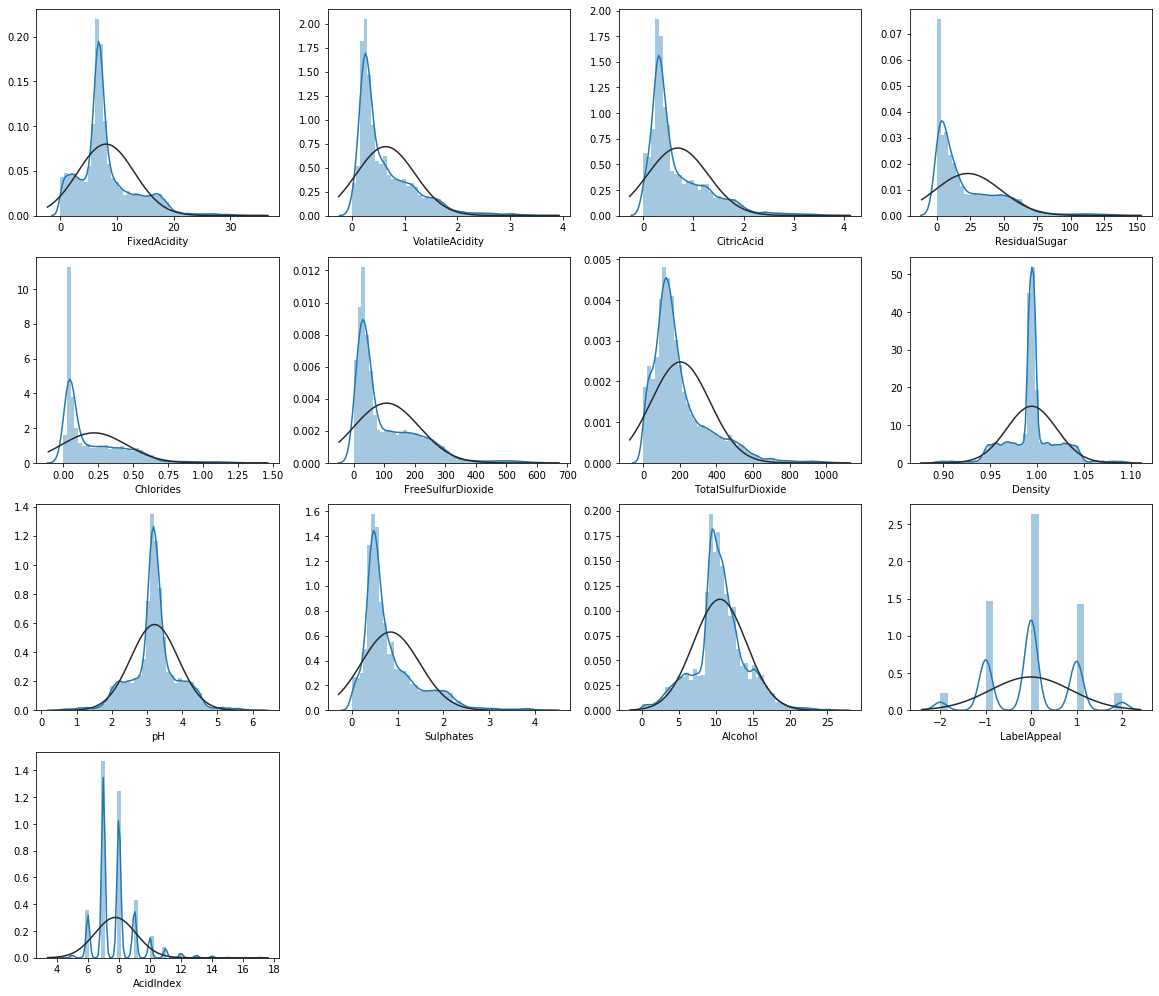

In [53]:
#distribution of variables from final model ready dataset

from scipy.stats import norm

plt.figure(figsize = (20,22))

for i in range(1,14):
    plt.subplot(5,4,i)
    sns.distplot(df_final[df_final.columns[i]], fit=norm)

Variables are coming out to be right skewed.

In [54]:
####### Some data exploration before we build models to predict TARGET############
# This is done to identify a trend based on Sales per unit which can help us conclude that 
# Star 4 wines are more profitable than others

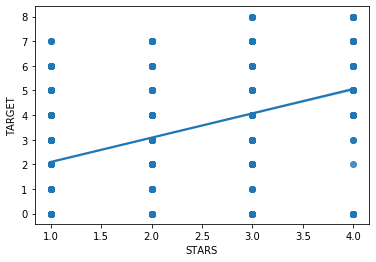

In [55]:
import seaborn as sns
#correlation between STARS AND TARGET
sns.regplot(x=df_final.STARS, y=df_final.TARGET)
plt.show()

In [56]:
#tallying the finding on the final model ready dataset
isStar1 = df_final['STARS']==1
star1 = df_final[isStar1]
star1_sales = star1.TARGET.sum()

isStar2 = df_final['STARS']==2
star2 = df_final[isStar2]
star2_sales = star2.TARGET.sum()

isStar3 = df_final['STARS']==3
star3 = df_final[isStar3]
star3_sales = star3.TARGET.sum()

isStar4 = df_final['STARS']==4
star4 = df_final[isStar4]
star4_sales = star4.TARGET.sum()

## How do the sales look for the different star rated wines
total_sales=[star1_sales, star2_sales, star3_sales, star4_sales]

avgSales_perUnit=[star1_sales/len(star1), star2_sales/len(star2), star3_sales/len(star3), star4_sales/len(star4)]

In [57]:
col={'Total Sales':total_sales}
stars=['1-star', '2-star','3-star','4-star']
df_totalSales=pd.DataFrame(data=col,index=stars)
df_totalSales

Total Sales
1-star         9706
2-star        15115
3-star        10588
4-star         3348

Total sales profile for each rating of the wine


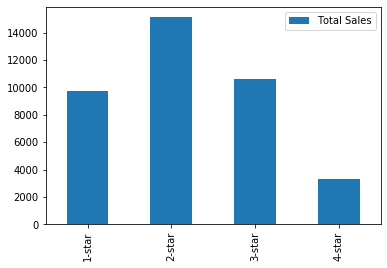

In [58]:
print('Total sales profile for each rating of the wine')
df_totalSales.plot(kind='bar')

In [59]:
##How many wines for each rating of the wine? #offerings
wines_perType =[len(star1),len(star2), len(star3), len(star4)]

In [60]:
col = {'Total no.of wine types': wines_perType}
df_wines_perType=pd.DataFrame(data=col,index=stars)
df_wines_perType

Total no.of wine types
1-star                    4598
2-star                    4934
3-star                    2612
4-star                     651

Offerings in each rating


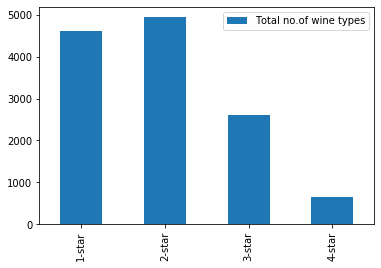

In [61]:
print('Offerings in each rating')
df_wines_perType.plot(kind='bar')

In [62]:
col={'Sales Per unit':avgSales_perUnit}
df_avgsalesPerUnit=pd.DataFrame(data=col,index=stars)
df_avgsalesPerUnit

Sales Per unit
1-star        2.110918
2-star        3.063437
3-star        4.053599
4-star        5.142857

Average sales per unit


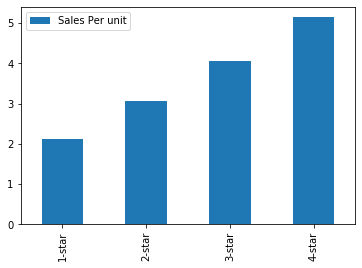

In [63]:
print('Average sales per unit')
df_avgsalesPerUnit.plot(kind='bar')

In [64]:
###### SOME ANALYSIS OF THE WINE TYPES ##########

4Star wine has maximum sales per unit. So even with a smaller volume, restaurants can earn more dollar value by selling S4 star wine. Specially, case is talking about predicting wine case sale for high-end restaurants then we can pitch that distributor can have more cases of 4star wine compared to 2/3 star wine. It will be more likeable at a high end restaurant owing to the elite audience with class taste. Similarly ROI for the ditributor will also be high.

Given a large wine manufacturer who intents to predict number of wine cases so as to adjust their wine offering to maximize sales. I believe, it should target on 4 star wines to be sold to high-end restaurants to derive maximum value sales and it should focus on 3 star and 2 star in the order to be maximize volume sales for regular restaurants.

# 3. BUILD MODELS TO PREDICT TARGET

Model Building Use at least 5 different techniques (e.g. k-NN Classifier, Naive Bayes Classifier, Decision Tree Classifier, Logistic Regression, MLP Classifier, Random Forest, Boosting, etc.). Describe how Hyperparameters were acquired, etc.

1.MLR for Target prediction

In [65]:
####### THE LINEAR REGRESSIONS BELOW USE UNSCALED df_final (without feature engineering) data to predict the TARGET column ########

In [66]:
## Splitting the dataset and assigning the response variable y = TARGET

In [67]:
y = df_final['TARGET'] #removing outcome i.e TARGET variable from the input variable dataset

train_X, valid_X, train_y, valid_y = train_test_split(df_final.drop('TARGET',axis=1), y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (7677, 14) Validation set: (5118, 14)


In [68]:
train_X

FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
11850           5.8            0.110        0.50           1.00      0.073   
1653            9.0            1.350        0.36          53.00      0.041   
7492           16.6            1.215        0.00           1.40      1.105   
8034            5.3            1.050        0.13           7.00      0.630   
10             14.9            0.320        0.34           1.30      0.042   
...             ...              ...         ...            ...        ...   
10955           6.7            1.740        0.08          28.95      0.165   
905             7.1            0.145        0.85          46.20      0.297   
5192            6.2            0.010        2.07           1.10      0.040   
12172           7.5            0.470        1.39           5.90      0.048   
235             7.2            0.220        0.69          43.00      0.538   

       FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  \
11850               39.0               178.0  0.99212  3.10       1.15   
1653                77.0               126.0  0.94212  3.50       1.19   
7492                11.0               148.0  0.93391  3.79       0.43   
8034               130.0               378.0  0.99558  3.06       2.64   
10                  20.0               209.5  0.95523  2.93       2.16   
...                  ...                 ...      ...   ...        ...   
10955              163.0                16.0  1.01917  3.43       1.96   
905                139.0                79.0  0.98624  3.14       0.88   
5192                38.0               185.0  1.00063  2.92       0.42   
12172              106.0               125.0  0.98619  3.09       0.26   
235                 34.0               140.0  0.99000  3.05       0.44   

       Alcohol  LabelAppeal  AcidIndex  STARS  
11850      9.9           -1        7.0    1.0  
1653      14.1            0        7.0    2.0  
7492      12.2            0        5.0    3.0  
8034       9.4            1        7.0    1.0  
10        12.0            2        8.0    3.0  
...        ...          ...        ...    ...  
10955     12.6           -1        7.0    1.0  
905       15.5           -1        8.0    1.0  
5192      13.7            0        8.0    2.0  
12172      5.2            2        8.0    2.0  
235       12.7            0        8.0    2.0  

[7677 rows x 14 columns]

In [69]:
valid_X

FixedAcidity  VolatileAcidity  CitricAcid  ResidualSugar  Chlorides  \
9493           18.7            0.200        0.56           1.90      0.278   
2619            3.3            0.060        0.65           8.30      0.083   
7970           17.7            0.410        0.01           2.80      0.498   
10823          16.1            0.635        0.10          47.20      0.080   
10281           7.3            1.210        0.03          27.00      0.103   
...             ...              ...         ...            ...        ...   
12718          12.5            1.220        0.38           9.70      0.516   
10690           2.3            0.960        0.64          31.10      0.053   
963             6.2            0.670        0.49           1.80      0.028   
7159            6.1            1.400        0.74          61.65      0.050   
11910          19.3            1.650        2.18          12.50      0.369   

       FreeSulfurDioxide  TotalSulfurDioxide  Density    pH  Sulphates  \
9493                64.0                60.0  1.07733  4.83      0.580   
2619                27.0               108.5  0.99640  3.00      0.350   
7970                39.0               287.0  1.03418  2.45      0.130   
10823               16.0               223.0  0.89720  3.58      0.490   
10281               37.0               189.0  0.99502  3.19      1.670   
...                  ...                 ...      ...   ...        ...   
12718               89.0               124.0  0.94813  3.37      2.055   
10690              177.0               453.0  0.99787  3.06      0.570   
963                 32.0               107.0  0.95681  3.74      0.675   
7159               250.0                55.0  0.99476  3.22      0.930   
11910               72.0                71.0  0.99760  3.27      0.610   

       Alcohol  LabelAppeal  AcidIndex  STARS  
9493     8.700            1       12.0    2.0  
2619     9.200            0        8.0    2.0  
7970     8.300            0        7.0    2.0  
10823   10.800            1        8.0    1.0  
10281   12.900            0        8.0    2.0  
...        ...          ...        ...    ...  
12718   11.000           -1        7.0    1.0  
10690   15.125           -1        7.0    2.0  
963     10.800            0        8.0    1.0  
7159    12.800            0        7.0    2.0  
11910   14.900            0       17.0    2.0  

[5118 rows x 14 columns]

In [70]:
def findsubsets(s, n): 
    return list(map(set, itertools.combinations(s, n)))

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

def exhaustive(model,train_X,train_y,valid_X,valid_y):
    low_err=600000**2
           
    for x in range(len(train_X.columns),0,-1):
        n=x
        #print("number of features "+str(n))
        ss=findsubsets(train_X.columns,n)
        print("_"*50)
        print(str(len(ss))+" model(s) using "+ str(n)+ " features")
        for z in range(0,len(ss)):
        
            model = model
            reg  = model.fit(train_X[ss[z]], train_y)
            pred_train = reg.predict(train_X[ss[z]])
            err_train= mean_squared_error(train_y, pred_train)
            
            
            pred_valid = reg.predict(valid_X[ss[z]])
            err_valid = mean_squared_error(valid_y, pred_valid)
            mae_valid = mean_absolute_error(valid_y,pred_valid)    
            r2_value = r2_score(valid_y, pred_valid) #The closer towards 1, the better the fit
           ######## adjusted_r2=adjusted_r2_score(valid_y, pred_valid, reg)

            if err_valid < low_err:
                low_err=err_valid
                low_err_features=list(ss[z])
                print("_"*50)
                print(low_err_features)
                print("RMSE train: "+str(err_train ** .5))
                print("MSE validation: "+str(low_err))
                print("RMSE validation: "+str(low_err ** .5)) #for rmse, the lower that value is, the better the fit
                print("MAE validation: "+str(mae_valid))
                print("R^2 Value: ", r2_value)         
                
                #adjusted_r2=1-(1-r2_value)*()
                #print("rsquared_adj\n",reg.rsquared_adj)
                
                #plotting a histogram
                abs(valid_y-pred_valid).hist()
                plt.show()
                
                #plotting a chart for Actual vs. predicted values. (there wasn'nt a visual comparison possible, so have commented out the code) )
                f = pd.DataFrame({'Actual': valid_y, 'Predicted': pred_valid})
                print(f.head(10))
                print('\n')
                #plotting a chart for Actual vs. predicted values. (there wasn'nt a visual comparison possible, so have commented out the code) )
                #f.plot(kind='bar',figsize=(10,8))
                #plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
                #plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
                #plt.show()
                
                param_df = pd.DataFrame({"Coefficient": list(reg.coef_),
                         "Feature": low_err_features})
                param_df[['Feature', 'Coefficient']]
                print(param_df)
                
                print("_"*50)

__________________________________________________
1 model(s) using 14 features
__________________________________________________
['Chlorides', 'pH', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density', 'Sulphates', 'ResidualSugar', 'CitricAcid', 'LabelAppeal', 'TotalSulfurDioxide']
RMSE train: 1.6168501439760954
MSE validation: 2.5793357261481638
RMSE validation: 1.6060310476912218
MAE validation: 1.2617900797799932
R^2 Value:  0.30695324782150224


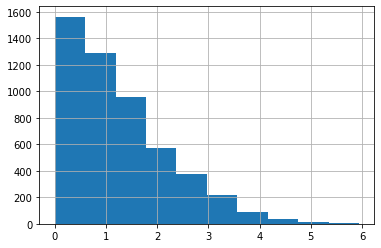

       Actual  Predicted
9493        0   2.045930
2619        3   3.102088
7970        3   3.322341
10823       0   2.875172
10281       0   2.859923
988         2   2.107703
9840        0   1.956711
335         4   2.668177
11270       0   3.618198
5764        5   3.757357


    Coefficient             Feature
0     -0.113146           Chlorides
1     -0.081802                  pH
2      0.736571               STARS
3     -0.133016     VolatileAcidity
4      0.000220   FreeSulfurDioxide
5     -0.300371           AcidIndex
6     -0.002375        FixedAcidity
7      0.015906             Alcohol
8     -1.478345             Density
9     -0.082539           Sulphates
10    -0.001158       ResidualSugar
11     0.045091          CitricAcid
12     0.527608         LabelAppeal
13     0.000417  TotalSulfurDioxide
__________________________________________________
__________________________________________________
14 model(s) using 13 features
__________________________________________________


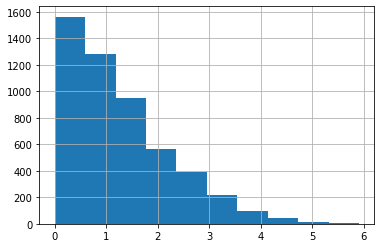

       Actual  Predicted
9493        0   2.014796
2619        3   3.062244
7970        3   3.264060
10823       0   2.848268
10281       0   2.927374
988         2   2.134024
9840        0   2.013318
335         4   2.639002
11270       0   3.599036
5764        5   3.755869


    Coefficient             Feature
0     -0.115988           Chlorides
1     -0.082379                  pH
2      0.737756               STARS
3     -0.133943     VolatileAcidity
4      0.000213   FreeSulfurDioxide
5     -0.301689           AcidIndex
6     -0.002373        FixedAcidity
7      0.015664             Alcohol
8     -1.509629             Density
9     -0.001145       ResidualSugar
10     0.045307          CitricAcid
11     0.527294         LabelAppeal
12     0.000422  TotalSulfurDioxide
__________________________________________________
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density', 'Su

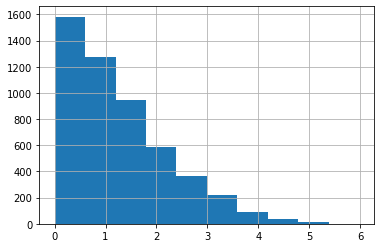

       Actual  Predicted
9493        0   2.191148
2619        3   3.087177
7970        3   3.258323
10823       0   2.904909
10281       0   2.858563
988         2   2.138551
9840        0   1.988634
335         4   2.638955
11270       0   3.642297
5764        5   3.767869


    Coefficient             Feature
0     -0.113842           Chlorides
1      0.737645               STARS
2     -0.134585     VolatileAcidity
3      0.000223   FreeSulfurDioxide
4     -0.297661           AcidIndex
5     -0.002369        FixedAcidity
6      0.016052             Alcohol
7     -1.476308             Density
8     -0.083193           Sulphates
9     -0.001153       ResidualSugar
10     0.044032          CitricAcid
11     0.526955         LabelAppeal
12     0.000409  TotalSulfurDioxide
__________________________________________________
__________________________________________________
['Chlorides', 'pH', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density

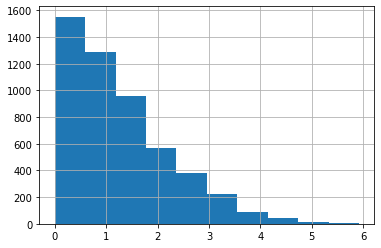

       Actual  Predicted
9493        0   2.022542
2619        3   3.084493
7970        3   3.297479
10823       0   2.902909
10281       0   2.863261
988         2   2.081880
9840        0   1.959221
335         4   2.643936
11270       0   3.600780
5764        5   3.803226


    Coefficient             Feature
0     -0.111547           Chlorides
1     -0.081710                  pH
2      0.736259               STARS
3     -0.133282     VolatileAcidity
4      0.000222   FreeSulfurDioxide
5     -0.300269           AcidIndex
6     -0.002365        FixedAcidity
7      0.015902             Alcohol
8     -1.481363             Density
9     -0.082247           Sulphates
10     0.046027          CitricAcid
11     0.528208         LabelAppeal
12     0.000413  TotalSulfurDioxide
__________________________________________________
__________________________________________________
91 model(s) using 12 features
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcid

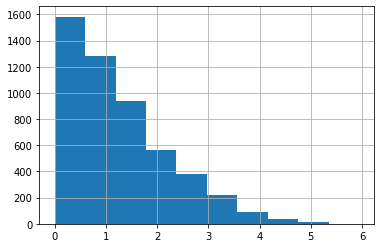

       Actual  Predicted
9493        0   2.160798
2619        3   3.046909
7970        3   3.199122
10823       0   2.878002
10281       0   2.926543
988         2   2.165302
9840        0   2.045920
335         4   2.609339
11270       0   3.623155
5764        5   3.766443


    Coefficient             Feature
0     -0.116711           Chlorides
1      0.738848               STARS
2     -0.135530     VolatileAcidity
3      0.000216   FreeSulfurDioxide
4     -0.298971           AcidIndex
5     -0.002367        FixedAcidity
6      0.015809             Alcohol
7     -1.507827             Density
8     -0.001140       ResidualSugar
9      0.044241          CitricAcid
10     0.526633         LabelAppeal
11     0.000414  TotalSulfurDioxide
__________________________________________________
__________________________________________________
['Chlorides', 'pH', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density', 'CitricAcid', 'LabelAppeal', 'Tot

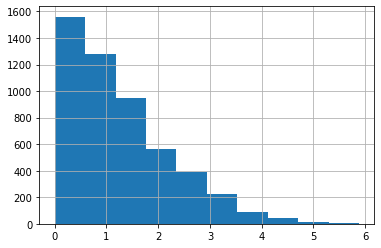

       Actual  Predicted
9493        0   1.991788
2619        3   3.044993
7970        3   3.239690
10823       0   2.875777
10281       0   2.930438
988         2   2.108409
9840        0   2.015601
335         4   2.615145
11270       0   3.581888
5764        5   3.801210


    Coefficient             Feature
0     -0.114397           Chlorides
1     -0.082286                  pH
2      0.737443               STARS
3     -0.134202     VolatileAcidity
4      0.000215   FreeSulfurDioxide
5     -0.301584           AcidIndex
6     -0.002363        FixedAcidity
7      0.015661             Alcohol
8     -1.512502             Density
9      0.046231          CitricAcid
10     0.527887         LabelAppeal
11     0.000418  TotalSulfurDioxide
__________________________________________________
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density', 'Sulphates', 'CitricAcid', 'LabelAppeal

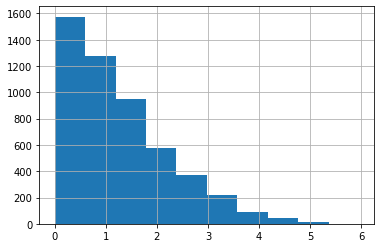

       Actual  Predicted
9493        0   2.167695
2619        3   3.069671
7970        3   3.233635
10823       0   2.932498
10281       0   2.861889
988         2   2.112800
9840        0   1.991098
335         4   2.614847
11270       0   3.624925
5764        5   3.813536


    Coefficient             Feature
0     -0.112248           Chlorides
1      0.737333               STARS
2     -0.134848     VolatileAcidity
3      0.000225   FreeSulfurDioxide
4     -0.297563           AcidIndex
5     -0.002359        FixedAcidity
6      0.016048             Alcohol
7     -1.479316             Density
8     -0.082901           Sulphates
9      0.044965          CitricAcid
10     0.527553         LabelAppeal
11     0.000405  TotalSulfurDioxide
__________________________________________________
__________________________________________________
364 model(s) using 11 features
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidInd

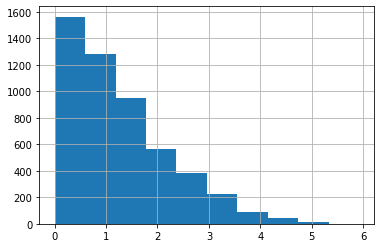

       Actual  Predicted
9493        0   2.137726
2619        3   3.029749
7970        3   3.174930
10823       0   2.905359
10281       0   2.929595
988         2   2.139762
9840        0   2.048157
335         4   2.585618
11270       0   3.606053
5764        5   3.811577


    Coefficient             Feature
0     -0.115126           Chlorides
1      0.738535               STARS
2     -0.135787     VolatileAcidity
3      0.000218   FreeSulfurDioxide
4     -0.298869           AcidIndex
5     -0.002357        FixedAcidity
6      0.015806             Alcohol
7     -1.510690             Density
8      0.045163          CitricAcid
9      0.527225         LabelAppeal
10     0.000410  TotalSulfurDioxide
__________________________________________________
__________________________________________________
1001 model(s) using 10 features
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'Alcohol', 'Density', 'CitricA

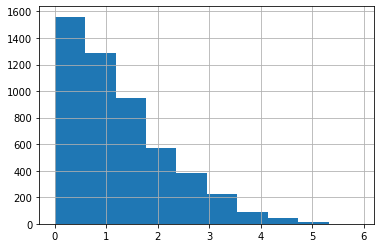

       Actual  Predicted
9493        0   2.156385
2619        3   3.018049
7970        3   3.199008
10823       0   2.922370
10281       0   2.927089
988         2   2.153475
9840        0   2.069341
335         4   2.570308
11270       0   3.587908
5764        5   3.811262


   Coefficient             Feature
0    -0.114645           Chlorides
1     0.738901               STARS
2    -0.135979     VolatileAcidity
3     0.000219   FreeSulfurDioxide
4    -0.300535           AcidIndex
5     0.015862             Alcohol
6    -1.502088             Density
7     0.045514          CitricAcid
8     0.527220         LabelAppeal
9     0.000410  TotalSulfurDioxide
__________________________________________________
__________________________________________________
2002 model(s) using 9 features
__________________________________________________
3003 model(s) using 8 features
__________________________________________________
3432 model(s) using 7 features
_________________________________________

In [72]:
# Exhaustive MLR without nomralization
exhaustive(model=LinearRegression(normalize=False,n_jobs=-1), train_X=train_X, train_y=train_y,valid_X=valid_X,valid_y=valid_y )

In [73]:
# Best Linear Regression Model without normalization is identifying 10 variables as significant
#['LabelAppeal', 'Density', 'AcidIndex', 'Chlorides', 'TotalSulfurDioxide', 'CitricAcid', 'Alcohol',
#'STARS', 'FreeSulfurDioxide', 'VolatileAcidity']
#train RMSE without Feature engineering 
train_RMSE_woFE = 1.618
#valid RMSE without Feature engineering 
valid_RMSE_woFE = 1.604

__________________________________________________
1 model(s) using 14 features
__________________________________________________
['Chlorides', 'pH', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density', 'Sulphates', 'ResidualSugar', 'CitricAcid', 'LabelAppeal', 'TotalSulfurDioxide']
RMSE train: 1.6168501439760954
MSE validation: 2.5793357261481638
RMSE validation: 1.6060310476912218
MAE validation: 1.261790079779993
R^2 Value:  0.30695324782150224


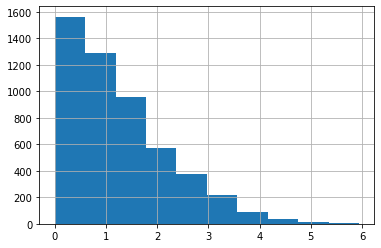

       Actual  Predicted
9493        0   2.045930
2619        3   3.102088
7970        3   3.322341
10823       0   2.875172
10281       0   2.859923
988         2   2.107703
9840        0   1.956711
335         4   2.668177
11270       0   3.618198
5764        5   3.757357


    Coefficient             Feature
0     -0.113146           Chlorides
1     -0.081802                  pH
2      0.736571               STARS
3     -0.133016     VolatileAcidity
4      0.000220   FreeSulfurDioxide
5     -0.300371           AcidIndex
6     -0.002375        FixedAcidity
7      0.015906             Alcohol
8     -1.478345             Density
9     -0.082539           Sulphates
10    -0.001158       ResidualSugar
11     0.045091          CitricAcid
12     0.527608         LabelAppeal
13     0.000417  TotalSulfurDioxide
__________________________________________________
__________________________________________________
14 model(s) using 13 features
__________________________________________________


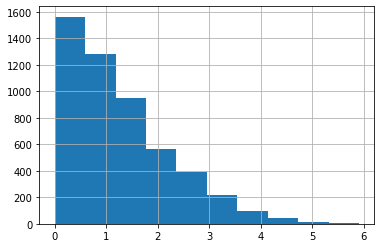

       Actual  Predicted
9493        0   2.014796
2619        3   3.062244
7970        3   3.264060
10823       0   2.848268
10281       0   2.927374
988         2   2.134024
9840        0   2.013318
335         4   2.639002
11270       0   3.599036
5764        5   3.755869


    Coefficient             Feature
0     -0.115988           Chlorides
1     -0.082379                  pH
2      0.737756               STARS
3     -0.133943     VolatileAcidity
4      0.000213   FreeSulfurDioxide
5     -0.301689           AcidIndex
6     -0.002373        FixedAcidity
7      0.015664             Alcohol
8     -1.509629             Density
9     -0.001145       ResidualSugar
10     0.045307          CitricAcid
11     0.527294         LabelAppeal
12     0.000422  TotalSulfurDioxide
__________________________________________________
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density', 'Su

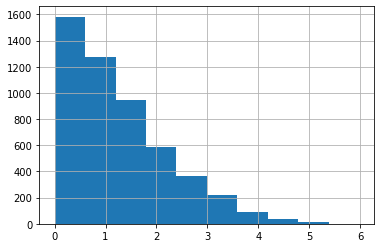

       Actual  Predicted
9493        0   2.191148
2619        3   3.087177
7970        3   3.258323
10823       0   2.904909
10281       0   2.858563
988         2   2.138551
9840        0   1.988634
335         4   2.638955
11270       0   3.642297
5764        5   3.767869


    Coefficient             Feature
0     -0.113842           Chlorides
1      0.737645               STARS
2     -0.134585     VolatileAcidity
3      0.000223   FreeSulfurDioxide
4     -0.297661           AcidIndex
5     -0.002369        FixedAcidity
6      0.016052             Alcohol
7     -1.476308             Density
8     -0.083193           Sulphates
9     -0.001153       ResidualSugar
10     0.044032          CitricAcid
11     0.526955         LabelAppeal
12     0.000409  TotalSulfurDioxide
__________________________________________________
__________________________________________________
['Chlorides', 'pH', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density

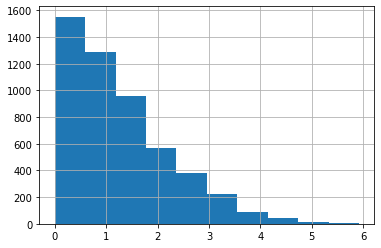

       Actual  Predicted
9493        0   2.022542
2619        3   3.084493
7970        3   3.297479
10823       0   2.902909
10281       0   2.863261
988         2   2.081880
9840        0   1.959221
335         4   2.643936
11270       0   3.600780
5764        5   3.803226


    Coefficient             Feature
0     -0.111547           Chlorides
1     -0.081710                  pH
2      0.736259               STARS
3     -0.133282     VolatileAcidity
4      0.000222   FreeSulfurDioxide
5     -0.300269           AcidIndex
6     -0.002365        FixedAcidity
7      0.015902             Alcohol
8     -1.481363             Density
9     -0.082247           Sulphates
10     0.046027          CitricAcid
11     0.528208         LabelAppeal
12     0.000413  TotalSulfurDioxide
__________________________________________________
__________________________________________________
91 model(s) using 12 features
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcid

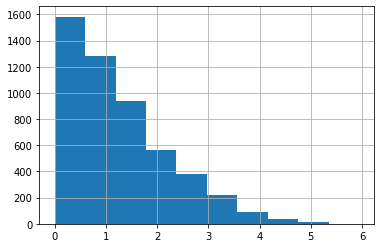

       Actual  Predicted
9493        0   2.160798
2619        3   3.046909
7970        3   3.199122
10823       0   2.878002
10281       0   2.926543
988         2   2.165302
9840        0   2.045920
335         4   2.609339
11270       0   3.623155
5764        5   3.766443


    Coefficient             Feature
0     -0.116711           Chlorides
1      0.738848               STARS
2     -0.135530     VolatileAcidity
3      0.000216   FreeSulfurDioxide
4     -0.298971           AcidIndex
5     -0.002367        FixedAcidity
6      0.015809             Alcohol
7     -1.507827             Density
8     -0.001140       ResidualSugar
9      0.044241          CitricAcid
10     0.526633         LabelAppeal
11     0.000414  TotalSulfurDioxide
__________________________________________________
__________________________________________________
['Chlorides', 'pH', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density', 'CitricAcid', 'LabelAppeal', 'Tot

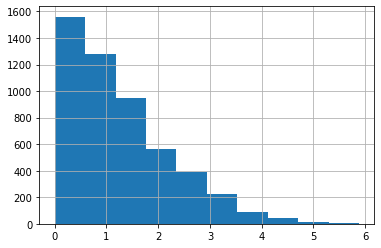

       Actual  Predicted
9493        0   1.991788
2619        3   3.044993
7970        3   3.239690
10823       0   2.875777
10281       0   2.930438
988         2   2.108409
9840        0   2.015601
335         4   2.615145
11270       0   3.581888
5764        5   3.801210


    Coefficient             Feature
0     -0.114397           Chlorides
1     -0.082286                  pH
2      0.737443               STARS
3     -0.134202     VolatileAcidity
4      0.000215   FreeSulfurDioxide
5     -0.301584           AcidIndex
6     -0.002363        FixedAcidity
7      0.015661             Alcohol
8     -1.512502             Density
9      0.046231          CitricAcid
10     0.527887         LabelAppeal
11     0.000418  TotalSulfurDioxide
__________________________________________________
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'FixedAcidity', 'Alcohol', 'Density', 'Sulphates', 'CitricAcid', 'LabelAppeal

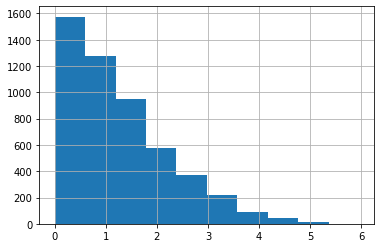

       Actual  Predicted
9493        0   2.167695
2619        3   3.069671
7970        3   3.233635
10823       0   2.932498
10281       0   2.861889
988         2   2.112800
9840        0   1.991098
335         4   2.614847
11270       0   3.624925
5764        5   3.813536


    Coefficient             Feature
0     -0.112248           Chlorides
1      0.737333               STARS
2     -0.134848     VolatileAcidity
3      0.000225   FreeSulfurDioxide
4     -0.297563           AcidIndex
5     -0.002359        FixedAcidity
6      0.016048             Alcohol
7     -1.479316             Density
8     -0.082901           Sulphates
9      0.044965          CitricAcid
10     0.527553         LabelAppeal
11     0.000405  TotalSulfurDioxide
__________________________________________________
__________________________________________________
364 model(s) using 11 features
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidInd

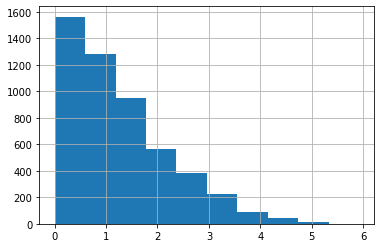

       Actual  Predicted
9493        0   2.137726
2619        3   3.029749
7970        3   3.174930
10823       0   2.905359
10281       0   2.929595
988         2   2.139762
9840        0   2.048157
335         4   2.585618
11270       0   3.606053
5764        5   3.811577


    Coefficient             Feature
0     -0.115126           Chlorides
1      0.738535               STARS
2     -0.135787     VolatileAcidity
3      0.000218   FreeSulfurDioxide
4     -0.298869           AcidIndex
5     -0.002357        FixedAcidity
6      0.015806             Alcohol
7     -1.510690             Density
8      0.045163          CitricAcid
9      0.527225         LabelAppeal
10     0.000410  TotalSulfurDioxide
__________________________________________________
__________________________________________________
1001 model(s) using 10 features
__________________________________________________
['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'Alcohol', 'Density', 'CitricA

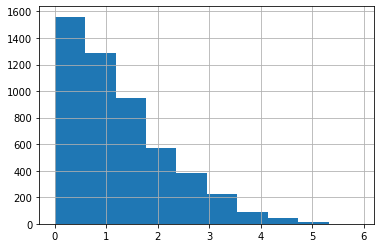

       Actual  Predicted
9493        0   2.156385
2619        3   3.018049
7970        3   3.199008
10823       0   2.922370
10281       0   2.927089
988         2   2.153475
9840        0   2.069341
335         4   2.570308
11270       0   3.587908
5764        5   3.811262


   Coefficient             Feature
0    -0.114645           Chlorides
1     0.738901               STARS
2    -0.135979     VolatileAcidity
3     0.000219   FreeSulfurDioxide
4    -0.300535           AcidIndex
5     0.015862             Alcohol
6    -1.502088             Density
7     0.045514          CitricAcid
8     0.527220         LabelAppeal
9     0.000410  TotalSulfurDioxide
__________________________________________________
__________________________________________________
2002 model(s) using 9 features
__________________________________________________
3003 model(s) using 8 features
__________________________________________________
3432 model(s) using 7 features
_________________________________________

In [74]:
#1. sklearn.linear_model.LinearRegression(normalize=True)...all subsets approach.
exhaustive(model=LinearRegression(normalize=True,n_jobs=-1), train_X=train_X, train_y=train_y,valid_X=valid_X,valid_y=valid_y )

In [75]:
#Best Linear regression model with normalization is giving out 10 significant features
# ['Chlorides', 'STARS', 'VolatileAcidity', 'FreeSulfurDioxide', 'AcidIndex', 'Alcohol', 
#'Density', 'CitricAcid', 'LabelAppeal', 'TotalSulfurDioxide']
#train RMSE without Feature engineering, normalized = true
train_RMSE_woFE_Nor = 1.618
#valid RMSE without Feature engineering ,normalized = true
valid_RMSE_woFE_Nor = 1.604

In [76]:
##############Adding code with feature engineering and the bar charts for error profile#########################

In [77]:
#doing a little bit of feature engineering
df_final['sulphurs']=df_final['FreeSulfurDioxide']+df_final['TotalSulfurDioxide']
#df_final['Acidity'] = df_final['FixedAcidity']+df_final['CitricAcid']
#df_final['sugars']=df_final['ResidualSugar']+df_final['Alcohol']

These combinations were tried on the model including Acidity, Sugar etc.The final cols that was fed in to the linear regression models made more sense in terms of PCA, subject matter and RMSE error profile

In [78]:
#cols = ['Acidity', 'VolatileAcidity','sugars', 'Chlorides','sulphurs',
#        'Sulphates', 'Alcohol', 'LabelAppeal', 'AcidIndex','STARS']

In [79]:
y=df_final['TARGET']
#train_X, temp_X, train_y, temp_y = train_test_split(df_final.drop('TARGET',axis=1), y, test_size=0.5, random_state=1)
#valid_X, test_X, valid_y, test_y = train_test_split(temp_X, temp_y, test_size=0.4, random_state=1)
train_X, valid_X, train_y, valid_y = train_test_split(df_final.drop('TARGET',axis=1), y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (7677, 15) Validation set: (5118, 15)


Error profile for Linear regression
RMSE train: 1.6181
RMSE validation: 1.6057
MSE validation: 2.578315940353971
MAE validation: 1.261343182835227
R^2 Value:  0.3072272560575834
[ 7.37635458e-01 -8.37906778e-02  1.60393637e-02 -1.35411289e-01
 -1.48542482e+00  3.52156367e-04 -2.98608780e-01 -1.16106323e-03
 -1.13291690e-01  5.27463039e-01]


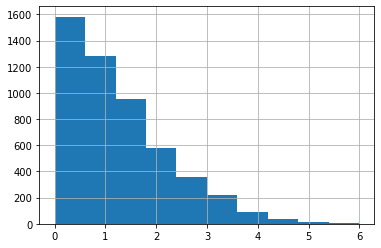

In [80]:
#single LinearRegression model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=LinearRegression()
reg  = model.fit(train_X[cols], train_y) 

pred_train = reg.predict(train_X[cols])  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X[cols])  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_lin=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_lin =round((mean_squared_error(valid_y,pred_valid))**0.5,4)
pred_LinReg = pd.DataFrame(pred_train)
mae_valid = mean_absolute_error(valid_y,pred_valid)

print('Error profile for Linear regression')
print("RMSE train: "+str(trainRMSE_lin))
print("RMSE validation: "+str(validRMSE_lin))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()


Error profile for Lasso
RMSE train: 1.9244
RMSE validation: 1.9292
MSE validation: 3.7217349251596583
MAE validation: 1.5650540433219042
R^2 Value:  -2.233920215477525e-07
[ 0. -0.  0. -0. -0.  0. -0. -0. -0.  0.]


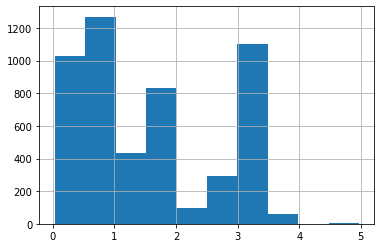

In [81]:
#single  Lasso model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=Lasso(normalize=True, alpha=1.0)
reg  = model.fit(train_X[cols], train_y) 

pred_train = reg.predict(train_X[cols])  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X[cols])  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_Lasso=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_Lasso =round((mean_squared_error(valid_y,pred_valid))**0.5,4)

pred_Lasso = pd.DataFrame(pred_train)

mae_valid = mean_absolute_error(valid_y,pred_valid)
print('Error profile for Lasso')
print("RMSE train: "+str(trainRMSE_Lasso))
print("RMSE validation: "+str(validRMSE_Lasso))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

Error profile for LassoCV
RMSE train: 1.6181
RMSE validation: 1.6057
MSE validation: 2.578325491574856
MAE validation: 1.2614515734462914
R^2 Value:  0.30722468972139594
[ 7.37083075e-01 -8.25258273e-02  1.57990645e-02 -1.34001347e-01
 -1.45404270e+00  3.47773081e-04 -2.98105068e-01 -1.12575129e-03
 -1.09787102e-01  5.26717632e-01]


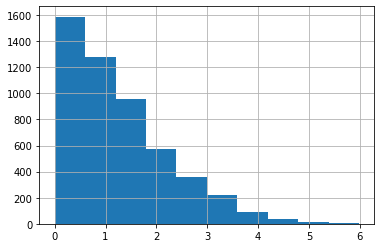

In [82]:
#single LassoCV model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=LassoCV(normalize=True, cv=5)
reg  = model.fit(train_X[cols], train_y) 

pred_train = reg.predict(train_X[cols])  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X[cols])  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_LassoCV=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_LassoCV =round((mean_squared_error(valid_y,pred_valid))**0.5,4)

pred_LassoCV = pd.DataFrame(pred_train)

mae_valid = mean_absolute_error(valid_y,pred_valid)
print('Error profile for LassoCV')
print("RMSE train: "+str(trainRMSE_LassoCV))
print("RMSE validation: "+str(validRMSE_LassoCV))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

Error profile for Ridge
RMSE train: 1.6785
RMSE validation: 1.6746
MSE validation: 2.804421832615545
MAE validation: 1.3480552934348953
R^2 Value:  0.2464744224145139
[ 4.16805040e-01 -5.22412936e-02  1.08312268e-02 -8.47096560e-02
 -9.36984681e-01  1.81180287e-04 -1.58196241e-01 -5.82157419e-04
 -6.19523316e-02  3.19134853e-01]


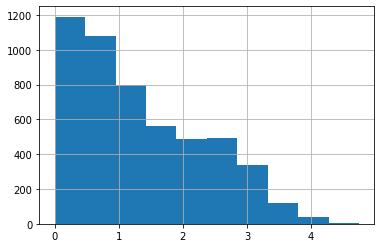

In [83]:
#single Ridge model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=Ridge(normalize=True,alpha=1.0)
reg  = model.fit(train_X[cols], train_y) 

pred_train = reg.predict(train_X[cols])  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X[cols])  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_Ridge=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_Ridge =round((mean_squared_error(valid_y,pred_valid))**0.5,4)

pred_Ridge = pd.DataFrame(pred_train)

mae_valid = mean_absolute_error(valid_y,pred_valid)
print('Error profile for Ridge')
print("RMSE train: "+str(trainRMSE_Ridge))
print("RMSE validation: "+str(validRMSE_Ridge))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

Error profile for RidgeCV
RMSE train: 1.6198
RMSE validation: 1.6089
MSE validation: 2.5884101746647965
MAE validation: 1.2676771982226716
R^2 Value:  0.3045150165325281
[ 6.83942255e-01 -7.93796955e-02  1.54595419e-02 -1.28250071e-01
 -1.41023688e+00  3.22079393e-04 -2.74151603e-01 -1.05353272e-03
 -1.04601533e-01  4.96333066e-01]


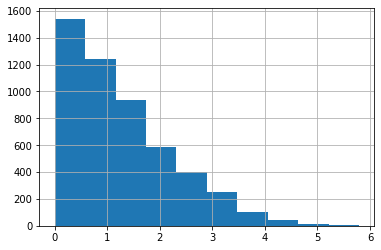

In [84]:
#single RidgeCV model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=RidgeCV(normalize=True, cv=5)
reg  = model.fit(train_X[cols], train_y) 

pred_train = reg.predict(train_X[cols])  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X[cols])  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_RidgeCV=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_RidgeCV =round((mean_squared_error(valid_y,pred_valid))**0.5,4)

pred_RidgeCV = pd.DataFrame(pred_train)

mae_valid = mean_absolute_error(valid_y,pred_valid)
print('Error profile for RidgeCV')
print("RMSE train: "+str(trainRMSE_RidgeCV))
print("RMSE validation: "+str(validRMSE_RidgeCV))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

In [85]:
##collating results

In [86]:
df_Results = pd.DataFrame(df_final['TARGET'])
df_Results['Linear_Reg']=round(pred_LinReg)
df_Results['Lasso']=round(pred_Lasso)
df_Results['LassoCV']=round(pred_LassoCV)
df_Results['Ridge']=round(pred_Ridge)
df_Results['RidgeCV']=round(pred_RidgeCV)

In [87]:
df_Results.head(100)

TARGET  Linear_Reg  Lasso  LassoCV  Ridge  RidgeCV
0        3         2.0    3.0      2.0    2.0      2.0
1        3         3.0    3.0      3.0    3.0      3.0
2        5         5.0    3.0      5.0    4.0      4.0
3        3         3.0    3.0      3.0    3.0      3.0
4        4         5.0    3.0      5.0    4.0      5.0
..     ...         ...    ...      ...    ...      ...
95       4         3.0    3.0      3.0    3.0      3.0
96       5         3.0    3.0      3.0    3.0      3.0
97       5         3.0    3.0      3.0    3.0      3.0
98       4         3.0    3.0      3.0    3.0      3.0
99       4         2.0    3.0      2.0    2.0      2.0

[100 rows x 6 columns]

In [89]:
#collating error profiles
#train RMSE without Feature engineering 
#train_RMSE_woFE = 1.618
#valid RMSE without Feature engineering 
#valid_RMSE_woFE = 1.604
train_RMSE_woFE = 1.618
#valid RMSE without Feature engineering 
valid_RMSE_woFE = 1.604

In [90]:
train_error =[train_RMSE_woFE,trainRMSE_lin,trainRMSE_Lasso,trainRMSE_LassoCV,trainRMSE_Ridge,trainRMSE_RidgeCV]
valid_error=[valid_RMSE_woFE,validRMSE_lin,validRMSE_Lasso,validRMSE_LassoCV,validRMSE_Ridge,validRMSE_RidgeCV]

In [91]:
col={'Train Error':train_error,'Validation Error':valid_error}
models=['Linear Reg without FE','Linear Reg with FE','Lasso','Lasso CV','Ridge','RidgeCV']
df_error=pd.DataFrame(data=col,index=models)
df_error

Train Error  Validation Error
Linear Reg without FE       1.6180            1.6040
Linear Reg with FE          1.6181            1.6057
Lasso                       1.9244            1.9292
Lasso CV                    1.6181            1.6057
Ridge                       1.6785            1.6746
RidgeCV                     1.6198            1.6089

<Figure size 1440x1800 with 0 Axes>

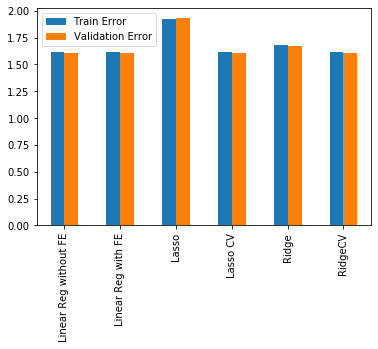

In [92]:
plt.figure(figsize=(20,25))
df_error.plot(kind='bar')

In [93]:
#The above results are for the following conditions
#df_final data is unscaled
#Columns used - cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
#                       'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']
#where sulphurs is made by adding up sulphur-di-oxides 
#df_final['sulphurs']=df_final['FreeSulfurDioxide']+df_final['TotalSulfurDioxide']
#df_final['Acidity'] = df_final['FixedAcidity']+df_final['CitricAcid']
#df_final['sugars']=df_final['ResidualSugar']+df_final['Alcohol']

In [94]:
##### Linear regression models for scaled data in df_final and feature engineering #########

In [95]:
# Assigning the response variable
y = df_final['TARGET'] 

#splitting the df_final dataset into a training set (60%) and a validiation set (40%).
train_X, valid_X, train_y, valid_y = train_test_split(df_final, y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (7677, 16) Validation set: (5118, 16)


In [96]:
#columns of interest
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

In [97]:
train_X2 = train_X[cols] #taking only the columns of interest cols
valid_X2 = valid_X[cols] #taking only the columns of interest cols

In [98]:
#scaling the training dataset
#train_X2_scaled - made from df_final[cols] and scaled using MinMaxScaler
#valid_X2_scaled - made from df_final[cols] and scaled using MinMaxScaler

scaler = preprocessing.MinMaxScaler()
scaler.fit(train_X2.iloc[:,:-1])
train_X2_scaled=pd.DataFrame(scaler.transform(train_X2.iloc[:,:-1]), columns=train_X2.columns[:-1])
valid_X2_scaled=pd.DataFrame(scaler.transform(valid_X2.iloc[:,:-1]), columns=valid_X2.columns[:-1])

__________________________________________________
1 model(s) using 9 features
__________________________________________________
['sulphurs', 'Chlorides', 'STARS', 'VolatileAcidity', 'AcidIndex', 'Alcohol', 'Density', 'Sulphates', 'ResidualSugar']
RMSE train: 1.6757746473857058
MSE validation: 2.7585049511464743
RMSE validation: 1.6608747548043694
MAE validation: 1.345085132834119
R^2 Value:  0.2588119189449972


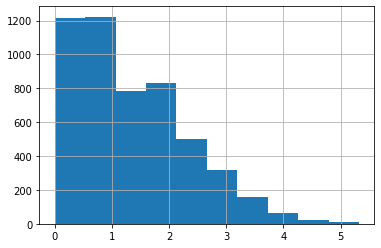

       Actual  Predicted
9493        0   1.766370
2619        3   3.096014
7970        3   3.289082
10823       0   2.237666
10281       0   2.871393
988         2   2.431063
9840        0   2.332472
335         4   2.185308
11270       0   3.108439
5764        5   3.057287


   Coefficient          Feature
0     0.466147         sulphurs
1    -0.160007        Chlorides
2     2.799978            STARS
3    -0.517870  VolatileAcidity
4    -3.657612        AcidIndex
5     0.321052          Alcohol
6    -0.363016          Density
7    -0.337318        Sulphates
8    -0.208879    ResidualSugar
__________________________________________________
__________________________________________________
9 model(s) using 8 features
__________________________________________________
['sulphurs', 'Chlorides', 'STARS', 'VolatileAcidity', 'AcidIndex', 'Alcohol', 'Density', 'Sulphates']
RMSE train: 1.6761747671878815
MSE validation: 2.754250551991709
RMSE validation: 1.6595934899823237
MAE validation: 1.3

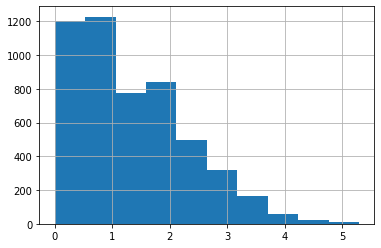

       Actual  Predicted
9493        0   1.735565
2619        3   3.073852
7970        3   3.258551
10823       0   2.273205
10281       0   2.876822
988         2   2.397270
9840        0   2.336357
335         4   2.154620
11270       0   3.085835
5764        5   3.112706


   Coefficient          Feature
0     0.462377         sulphurs
1    -0.157402        Chlorides
2     2.799642            STARS
3    -0.519000  VolatileAcidity
4    -3.655264        AcidIndex
5     0.320806          Alcohol
6    -0.363990          Density
7    -0.335646        Sulphates
__________________________________________________
__________________________________________________
36 model(s) using 7 features
__________________________________________________
['sulphurs', 'Chlorides', 'STARS', 'VolatileAcidity', 'AcidIndex', 'Alcohol', 'Density']
RMSE train: 1.6769279820915712
MSE validation: 2.753769841477934
RMSE validation: 1.6594486558727672
MAE validation: 1.3436244602795904
R^2 Value:  0.26008420480671

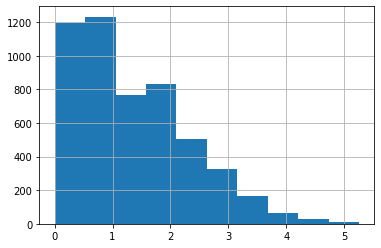

       Actual  Predicted
9493        0   1.707203
2619        3   3.035217
7970        3   3.201440
10823       0   2.246907
10281       0   2.941565
988         2   2.422289
9840        0   2.391541
335         4   2.126517
11270       0   3.068194
5764        5   3.109652


   Coefficient          Feature
0     0.463880         sulphurs
1    -0.160940        Chlorides
2     2.802730            STARS
3    -0.522336  VolatileAcidity
4    -3.671679        AcidIndex
5     0.314700          Alcohol
6    -0.370316          Density
__________________________________________________
__________________________________________________
84 model(s) using 6 features
__________________________________________________
126 model(s) using 5 features
__________________________________________________
126 model(s) using 4 features
__________________________________________________
84 model(s) using 3 features
__________________________________________________
36 model(s) using 2 features
______________

In [99]:
# Exhaustive MLR without nomralization - datasets passed - train_X2_scaled,valid_X2_scaled
exhaustive(model=LinearRegression(normalize=False,n_jobs=-1), train_X=train_X2_scaled, train_y=train_y,valid_X=valid_X2_scaled,valid_y=valid_y )

MLR with Feature engineering along with scaled data gave best model with 7 features
['VolatileAcidity', 'AcidIndex', 'STARS', 'Chlorides', 'sulphurs', 'Density', 'Alcohol']
RMSE train: 1.6769279820915712
MSE validation: 2.753769841477934
RMSE validation: 1.6594486558727672
MAE validation: 1.3436244602795904
R^2 Value:  0.2600842048067107

__________________________________________________
1 model(s) using 9 features
__________________________________________________
['sulphurs', 'Chlorides', 'STARS', 'VolatileAcidity', 'AcidIndex', 'Alcohol', 'Density', 'Sulphates', 'ResidualSugar']
RMSE train: 1.6757746473857058
MSE validation: 2.7585049511464743
RMSE validation: 1.6608747548043694
MAE validation: 1.3450851328341191
R^2 Value:  0.2588119189449972


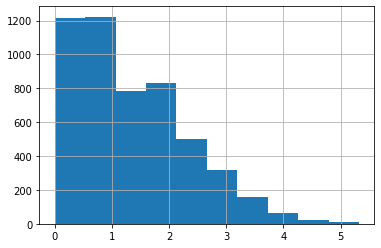

       Actual  Predicted
9493        0   1.766370
2619        3   3.096014
7970        3   3.289082
10823       0   2.237666
10281       0   2.871393
988         2   2.431063
9840        0   2.332472
335         4   2.185308
11270       0   3.108439
5764        5   3.057287


   Coefficient          Feature
0     0.466147         sulphurs
1    -0.160007        Chlorides
2     2.799978            STARS
3    -0.517870  VolatileAcidity
4    -3.657612        AcidIndex
5     0.321052          Alcohol
6    -0.363016          Density
7    -0.337318        Sulphates
8    -0.208879    ResidualSugar
__________________________________________________
__________________________________________________
9 model(s) using 8 features
__________________________________________________
['sulphurs', 'Chlorides', 'STARS', 'VolatileAcidity', 'AcidIndex', 'Alcohol', 'Density', 'Sulphates']
RMSE train: 1.6761747671878817
MSE validation: 2.754250551991709
RMSE validation: 1.6595934899823237
MAE validation: 1.3

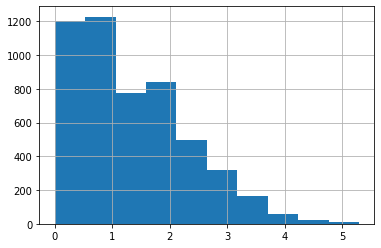

       Actual  Predicted
9493        0   1.735565
2619        3   3.073852
7970        3   3.258551
10823       0   2.273205
10281       0   2.876822
988         2   2.397270
9840        0   2.336357
335         4   2.154620
11270       0   3.085835
5764        5   3.112706


   Coefficient          Feature
0     0.462377         sulphurs
1    -0.157402        Chlorides
2     2.799642            STARS
3    -0.519000  VolatileAcidity
4    -3.655264        AcidIndex
5     0.320806          Alcohol
6    -0.363990          Density
7    -0.335646        Sulphates
__________________________________________________
__________________________________________________
36 model(s) using 7 features
__________________________________________________
['sulphurs', 'Chlorides', 'STARS', 'VolatileAcidity', 'AcidIndex', 'Alcohol', 'Density']
RMSE train: 1.6769279820915712
MSE validation: 2.7537698414779346
RMSE validation: 1.6594486558727675
MAE validation: 1.3436244602795904
R^2 Value:  0.2600842048067

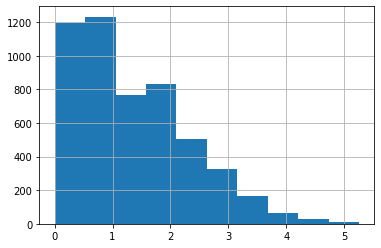

       Actual  Predicted
9493        0   1.707203
2619        3   3.035217
7970        3   3.201440
10823       0   2.246907
10281       0   2.941565
988         2   2.422289
9840        0   2.391541
335         4   2.126517
11270       0   3.068194
5764        5   3.109652


   Coefficient          Feature
0     0.463880         sulphurs
1    -0.160940        Chlorides
2     2.802730            STARS
3    -0.522336  VolatileAcidity
4    -3.671679        AcidIndex
5     0.314700          Alcohol
6    -0.370316          Density
__________________________________________________
__________________________________________________
84 model(s) using 6 features
__________________________________________________
126 model(s) using 5 features
__________________________________________________
126 model(s) using 4 features
__________________________________________________
84 model(s) using 3 features
__________________________________________________
36 model(s) using 2 features
______________

In [100]:
# Exhaustive MLR with nomralization - datasets passed - train_X2_scaled,valid_X2_scaled
#1.sklearn.linear_model.LinearRegression(normalize=True)...all subsets approach.
exhaustive(model=LinearRegression(normalize=True,n_jobs=-1), train_X=train_X2_scaled, train_y=train_y,valid_X=valid_X2_scaled,valid_y=valid_y )

 MLR without feature engineered data and normalization gave best model with 7 features:
['VolatileAcidity', 'AcidIndex', 'STARS', 'Chlorides', 'sulphurs', 'Density', 'Alcohol']
RMSE train: 1.6769279820915712
MSE validation: 2.753769841477934
RMSE validation: 1.6594486558727672
MAE validation: 1.3436244602795904
R^2 Value:  0.2600842048067107

In [101]:
#collating error profiles
#train RMSE with Feature engineering for scaled dataset
train_RMSE_wFE_scaled = 1.676
#valid RMSE with Feature engineering for scaled dataset
valid_RMSE_wFE_scaled = 1.659

Error profile for Linear regression
RMSE train: 1.6758
RMSE validation: 1.6609
MSE validation: 2.7585049511464748
MAE validation: 1.3450851328341193
R^2 Value:  0.2588119189449971
[ 2.79997753 -0.33731779  0.3210517  -0.5178695  -0.36301624  0.46614676
 -3.65761242 -0.20887897 -0.16000729]


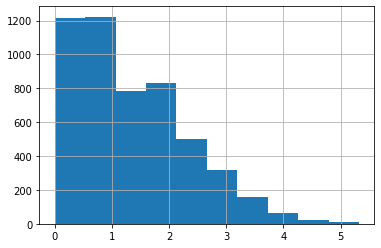

In [102]:
#single LinearRegression model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=LinearRegression()
reg  = model.fit(train_X2_scaled, train_y) 

pred_train = reg.predict(train_X2_scaled)  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X2_scaled)  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_lin_sc=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_lin_sc =round((mean_squared_error(valid_y,pred_valid))**0.5,4)
pred_LinReg = pd.DataFrame(pred_train)
mae_valid = mean_absolute_error(valid_y,pred_valid)

print('Error profile for Linear regression')
print("RMSE train: "+str(trainRMSE_lin_sc))
print("RMSE validation: "+str(validRMSE_lin_sc))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

Error profile for Lasso
RMSE train: 1.9244
RMSE validation: 1.9292
MSE validation: 3.7217349251596583
MAE validation: 1.5650540433219042
R^2 Value:  -2.233920215477525e-07
[ 0. -0.  0. -0. -0.  0. -0. -0. -0.]


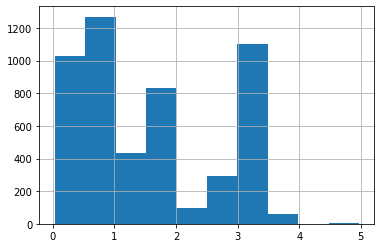

In [103]:
#single  Lasso model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=Lasso(normalize=True, alpha=1.0)
reg  = model.fit(train_X2_scaled, train_y) 

pred_train = reg.predict(train_X2_scaled)  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X2_scaled)  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_Lasso_sc=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_Lasso_sc =round((mean_squared_error(valid_y,pred_valid))**0.5,4)

pred_Lasso = pd.DataFrame(pred_train)

mae_valid = mean_absolute_error(valid_y,pred_valid)
print('Error profile for Lasso')
print("RMSE train: "+str(trainRMSE_Lasso_sc))
print("RMSE validation: "+str(validRMSE_Lasso_sc))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

Error profile for LassoCV
RMSE train: 1.6758
RMSE validation: 1.6609
MSE validation: 2.75849179083233
MAE validation: 1.3451178039912037
R^2 Value:  0.25881545501549896
[ 2.7974814  -0.33201467  0.31491787 -0.51281127 -0.35636746  0.46022957
 -3.65138438 -0.20383064 -0.15551676]


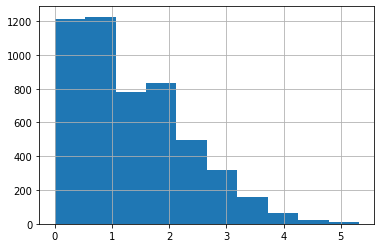

In [104]:
#single LassoCV model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=LassoCV(normalize=True, cv=5)
reg  = model.fit(train_X2_scaled, train_y) 

pred_train = reg.predict(train_X2_scaled)  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X2_scaled)  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_LassoCV_sc=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_LassoCV_sc =round((mean_squared_error(valid_y,pred_valid))**0.5,4)

pred_LassoCV = pd.DataFrame(pred_train)

mae_valid = mean_absolute_error(valid_y,pred_valid)
print('Error profile for LassoCV')
print("RMSE train: "+str(trainRMSE_LassoCV_sc))
print("RMSE validation: "+str(validRMSE_LassoCV_sc))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

Error profile for Ridge
RMSE train: 1.7362
RMSE validation: 1.7304
MSE validation: 2.9943045121005656
MAE validation: 1.4193257154475436
R^2 Value:  0.19545447453492382
[ 1.42615399 -0.21808457  0.26333874 -0.31698348 -0.21036949  0.23954668
 -2.00923841 -0.09555748 -0.08184666]


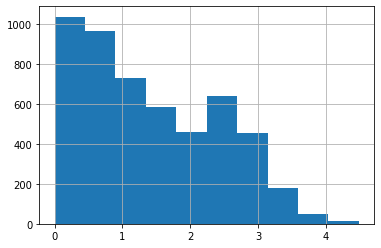

In [105]:
#single Ridge model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=Ridge(normalize=True,alpha=1.0)
reg  = model.fit(train_X2_scaled, train_y) 

pred_train = reg.predict(train_X2_scaled)  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X2_scaled)  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_Ridge_sc=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_Ridge_sc =round((mean_squared_error(valid_y,pred_valid))**0.5,4)

pred_Ridge = pd.DataFrame(pred_train)

mae_valid = mean_absolute_error(valid_y,pred_valid)
print('Error profile for Ridge')
print("RMSE train: "+str(trainRMSE_Ridge_sc))
print("RMSE validation: "+str(validRMSE_Ridge_sc))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

Error profile for RidgeCV
RMSE train: 1.6777
RMSE validation: 1.6643
MSE validation: 2.7698069822089586
MAE validation: 1.3502145060296662
R^2 Value:  0.25577515415262475
[ 2.55285652 -0.32237895  0.32520959 -0.48968001 -0.33879931  0.42558898
 -3.38269093 -0.18708514 -0.14565506]


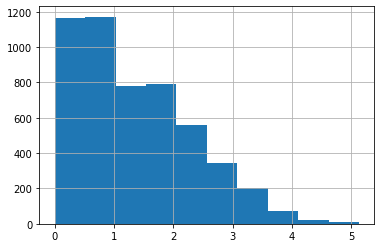

In [106]:
#single RidgeCV model using the features
cols = ['STARS', 'Sulphates', 'Alcohol', 'VolatileAcidity', 'Density', 
        'sulphurs', 'AcidIndex', 'ResidualSugar', 'Chlorides', 'LabelAppeal']

model=RidgeCV(normalize=True, cv=5)
reg  = model.fit(train_X2_scaled, train_y) 

pred_train = reg.predict(train_X2_scaled)  #predicts outcome training data
err_train= mean_squared_error(train_y, pred_train)

pred_valid = reg.predict(valid_X2_scaled)  #predicts outcome using the validation data
err_valid = mean_squared_error(valid_y, pred_valid)
trainRMSE_RidgeCV_sc=round((mean_squared_error(train_y,pred_train))**0.5,4)
validRMSE_RidgeCV_sc =round((mean_squared_error(valid_y,pred_valid))**0.5,4)

pred_RidgeCV = pd.DataFrame(pred_train)

mae_valid = mean_absolute_error(valid_y,pred_valid)
print('Error profile for RidgeCV')
print("RMSE train: "+str(trainRMSE_RidgeCV_sc))
print("RMSE validation: "+str(validRMSE_RidgeCV_sc))
print("MSE validation: "+str(err_valid))
print("MAE validation: "+str(mae_valid))
r2_value = r2_score(valid_y, pred_valid)
print("R^2 Value: ", r2_value)        
print(reg.coef_)
abs(valid_y-pred_valid).hist()

In [107]:
#collating results
df_Results_scaled = pd.DataFrame(df_final['TARGET'])
df_Results_scaled['Linear_Reg_scaled']=round(pred_LinReg)
df_Results_scaled['Lasso_scaled']=round(pred_Lasso)
df_Results_scaled['LassoCV_scaled']=round(pred_LassoCV)
df_Results_scaled['Ridge_scaled']=round(pred_Ridge)
df_Results_scaled['RidgeCV_scaled']=round(pred_RidgeCV)

In [108]:
df_Results_scaled.head(100)

TARGET  Linear_Reg_scaled  Lasso_scaled  LassoCV_scaled  Ridge_scaled  \
0        3                2.0           3.0             2.0           3.0   
1        3                3.0           3.0             3.0           3.0   
2        5                5.0           3.0             5.0           4.0   
3        3                2.0           3.0             2.0           3.0   
4        4                4.0           3.0             4.0           4.0   
..     ...                ...           ...             ...           ...   
95       4                3.0           3.0             3.0           3.0   
96       5                4.0           3.0             4.0           4.0   
97       5                3.0           3.0             3.0           3.0   
98       4                3.0           3.0             3.0           3.0   
99       4                2.0           3.0             2.0           3.0   

    RidgeCV_scaled  
0              2.0  
1              3.0  
2              5.0  
3              2.0  
4              4.0  
..             ...  
95             3.0  
96             4.0  
97             3.0  
98             3.0  
99             3.0  

[100 rows x 6 columns]

In [109]:
#collating error profiles
train_error_scaled =[train_RMSE_wFE_scaled,trainRMSE_lin_sc,trainRMSE_Lasso_sc,trainRMSE_LassoCV_sc,trainRMSE_Ridge_sc,trainRMSE_RidgeCV_sc]
valid_error_scaled=[valid_RMSE_wFE_scaled,validRMSE_lin_sc,validRMSE_Lasso_sc,validRMSE_LassoCV_sc,validRMSE_Ridge_sc,validRMSE_RidgeCV_sc]

In [110]:
col={'Scaled Train Error':train_error_scaled,'Scaled Validation Error':valid_error_scaled}
models=['Linear Reg w FE exhaustive scales','Linear Regression w FE scaled','Lasso scaled','Lasso CV scaled','Ridge scaled','RidgeCV scaled']
df_error_scaled=pd.DataFrame(data=col,index=models)
df_error_scaled

Scaled Train Error  Scaled Validation Error
Linear Reg w FE exhaustive scales              1.6760                   1.6590
Linear Regression w FE scaled                  1.6758                   1.6609
Lasso scaled                                   1.9244                   1.9292
Lasso CV scaled                                1.6758                   1.6609
Ridge scaled                                   1.7362                   1.7304
RidgeCV scaled                                 1.6777                   1.6643

<Figure size 1440x1800 with 0 Axes>

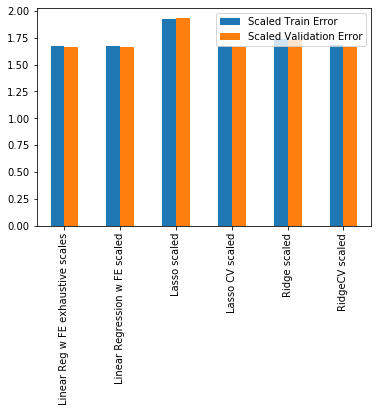

In [111]:
plt.figure(figsize=(20,25))
df_error_scaled.plot(kind='bar')

Multi Linear Regression model results with unscaled feature engineered data is better than scaled feature engineered data.

In [112]:
# Decision Trees
# df_final = unscaled with features
# df_model = unscaled without features

In [113]:
# Creating decision tree using df_final which is unscaled and has features engineered - 
# Results were exactly same as when we ran df_model which had no features engineered. 
# So we decided to just keep one.

In [114]:
# Creating decision tree using df_model which is unscaled and has no engineered features

In [123]:
df_model=df_model.drop(columns='sulphurs')
df_model.columns

Index(['TARGET', 'FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
       'Density', 'pH', 'Sulphates', 'Alcohol', 'LabelAppeal', 'AcidIndex',
       'STARS'],
      dtype='object')

In [124]:
y = df_model['TARGET'] #removing outcome i.e TARGET variable from the input variable dataset

train_X, valid_X, train_y, valid_y = train_test_split(df_model.drop('TARGET',axis=1), y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (7677, 14) Validation set: (5118, 14)


Improved parameters:  {'max_depth': 6, 'max_features': 6, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 8}
Tree has 111 nodes


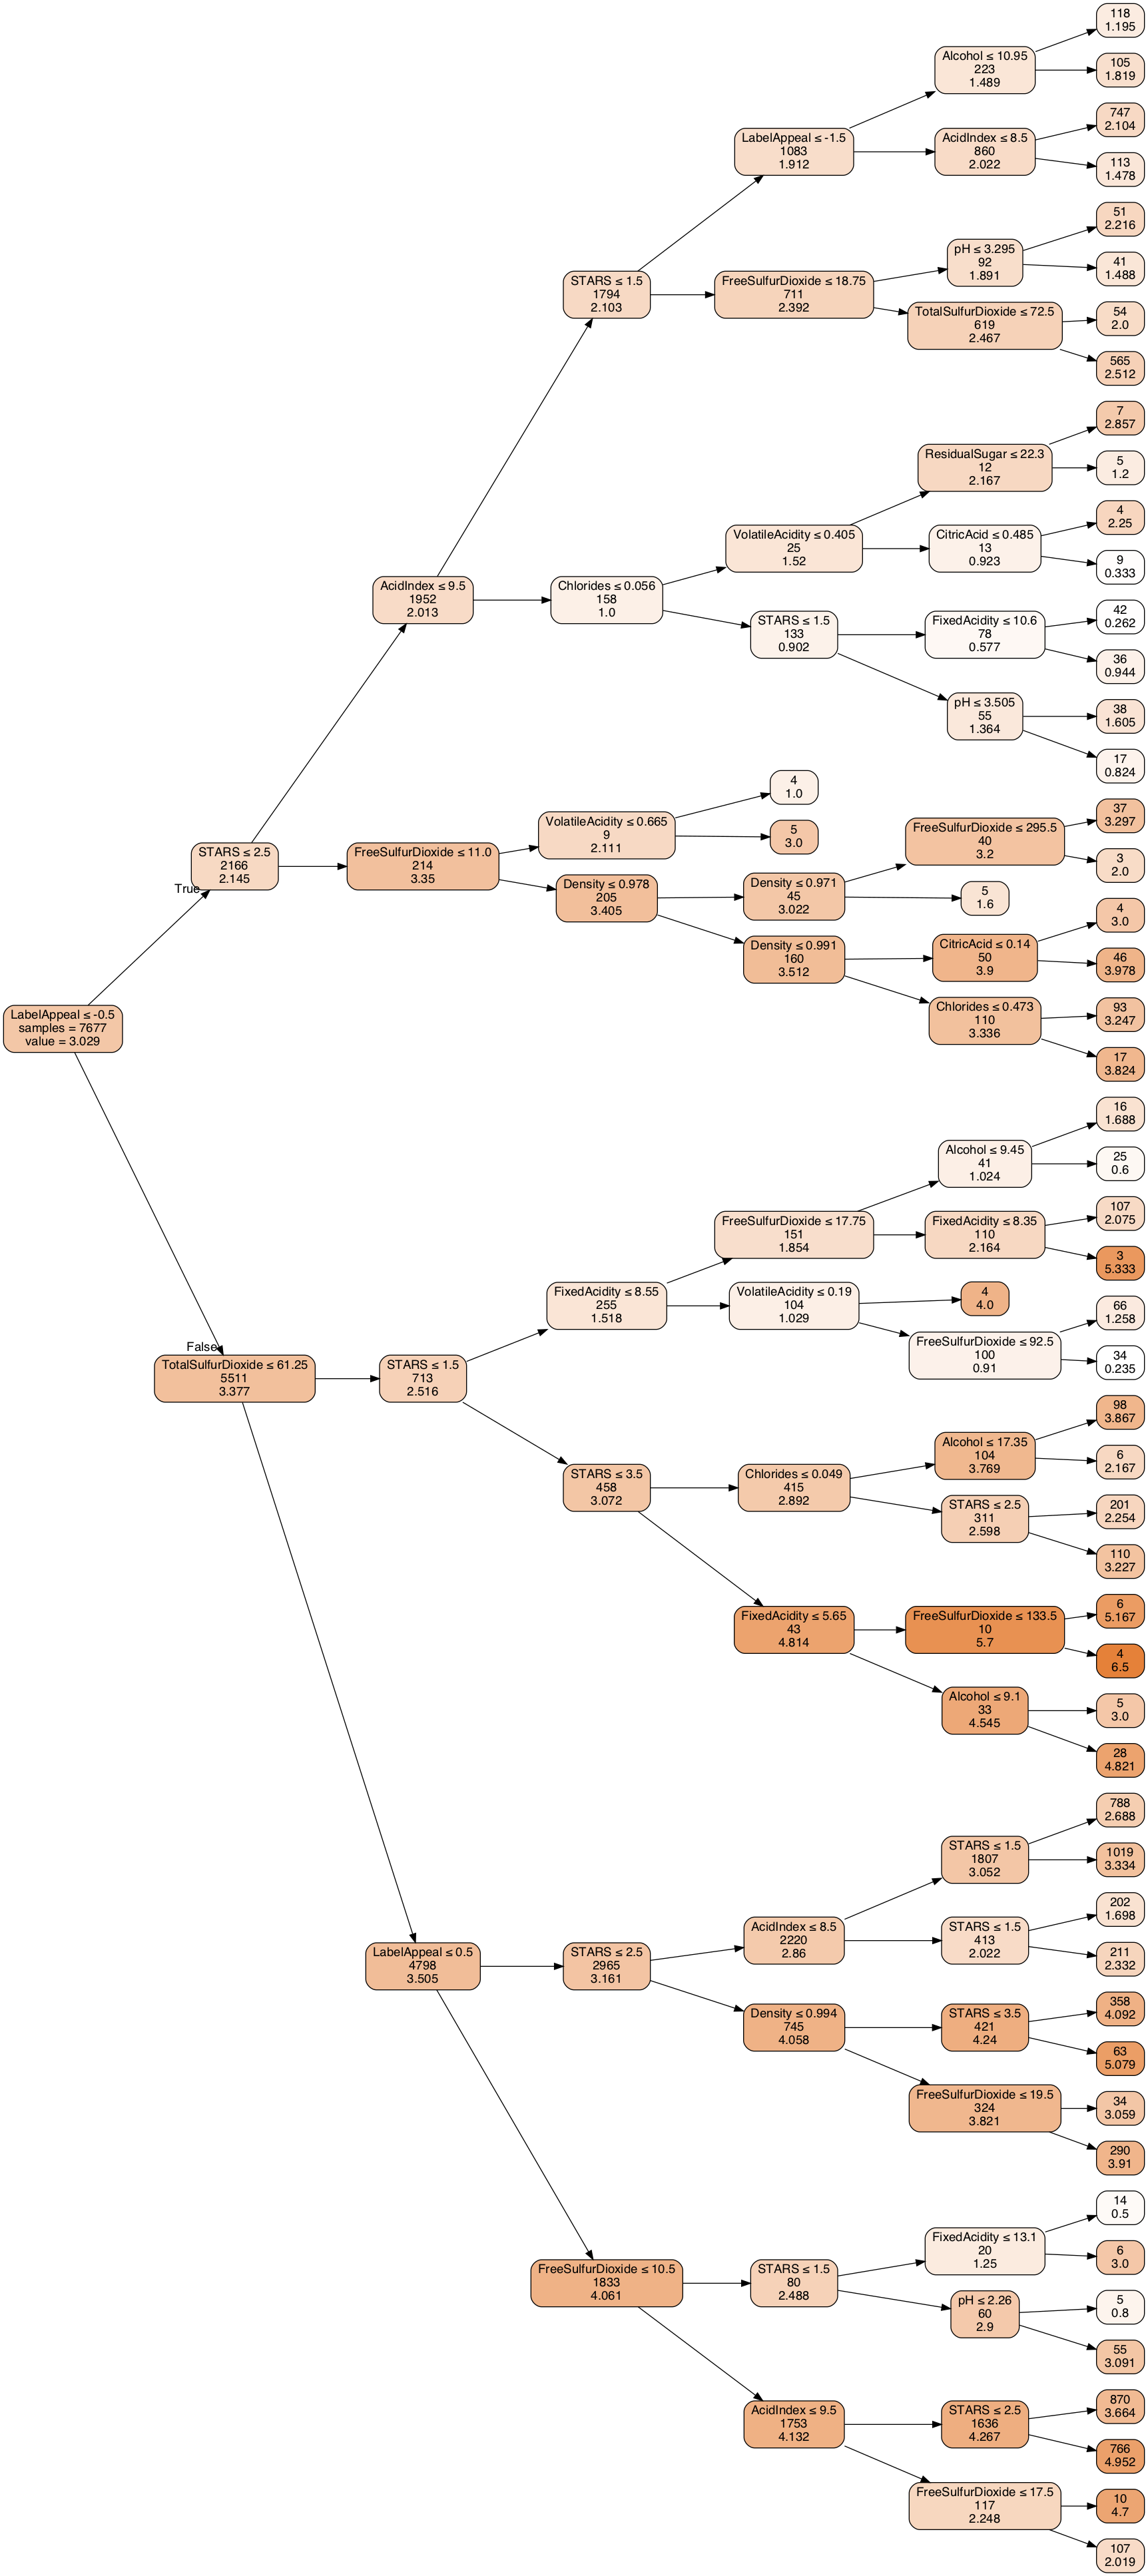

In [125]:
# user grid search to find optimized Decision tree Regressor

param_grid = {
    'max_depth': list(np.arange(1,8)), #
    'min_samples_split': list(np.arange(4,11)),# 
    'min_samples_leaf':  list(np.arange(1,5)) ,#
    'min_impurity_decrease': list(np.arange(0.0,0.01)), #
    'max_features': [5,6,7],    #
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1), 
                          param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

optRegTree = gridSearch.best_estimator_

print('Tree has {} nodes'.format(optRegTree.tree_.node_count))
plotDecisionTree(optRegTree, feature_names=train_X.columns, rotate=True)

#Create valid_y and predict_y in one dataframe <<CHECK>>
#importance = pd.DataFrame({'features': train_X.columns, 
#                           'importance': shallowTree.feature_importances_})

In [126]:
#Compare the prediction errors of the training and validation sets by examining their RMS error
RMSE_val_Decision= (mean_squared_error(valid_y, optRegTree.predict(valid_X))**.5)
"RMSE validation for Decision tree: "+str(mean_squared_error(valid_y, optRegTree.predict(valid_X))**.5)

'RMSE validation for Decision tree: 1.6541870955609734'

In [127]:
RMSE_train_Decision=(mean_squared_error(train_y, optRegTree.predict(train_X))**.5)
"RMSE training for Decision tree: "+str(mean_squared_error(train_y, optRegTree.predict(train_X))**.5)

'RMSE training for Decision tree: 1.602348091103032'

Text(0.5, 1.0, 'Validation')

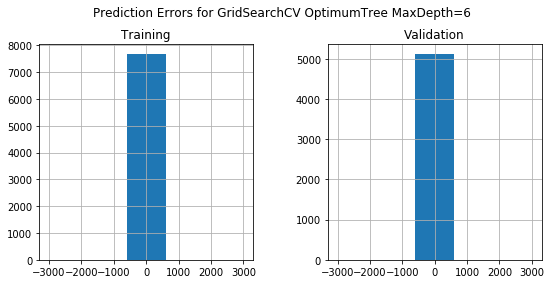

In [128]:
#plotting errors using a histogram

pred_error_train = pd.DataFrame({
    'residual':train_y - optRegTree.predict(train_X),
    'dataset' :'Training'  
})
pred_error_valid = pd.DataFrame({
    'residual':valid_y - optRegTree.predict(valid_X),
    'dataset' :'Validation'  
})
fig,axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(9,4)
common ={'bins':5, 'range': [-3000, 3000]}
pred_error_train.hist(ax=axes[0],**common)
pred_error_valid.hist(ax=axes[1],**common)

plt.suptitle('Prediction Errors for GridSearchCV OptimumTree MaxDepth=6')
plt.subplots_adjust(bottom=0.1,top=0.85, wspace=0.35)
axes[0].set_title('Training')
axes[1].set_title('Validation')

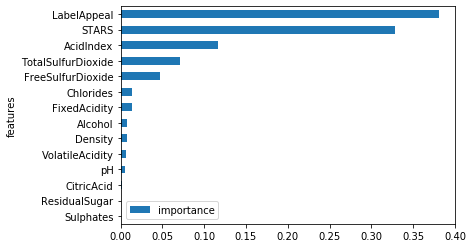

In [129]:
# Variable importance based on Gini Importance
importance = pd.DataFrame({'features': train_X.columns, 
                           'importance': optRegTree.feature_importances_})
importance.index=importance.features
importance.sort_values(by='importance', ascending=True).plot.barh()

In [130]:
#Random Forest Regressor
# user grid search to find optimized tree

param_grid = {
    'max_depth': list(np.arange(3,10)), 
    'min_samples_split':list(np.arange(2,12)), 
#    'max_leaf_nodes': [52],#list(np.arange(35,54)),  
    'min_samples_leaf': list(np.arange(2,6)) , #does not improve MSE
    'max_features': [5,6,7],    
#    'n_estimators': list(np.arange(100,1200,200)),
}
 
gridSearch = GridSearchCV(RandomForestRegressor(random_state=1), 
                          param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

rf = gridSearch.best_estimator_

print("RMSE: "+str(mean_squared_error(valid_y, rf.predict(valid_X))**.5))


Improved parameters:  {'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
RMSE: 1.569504672618949


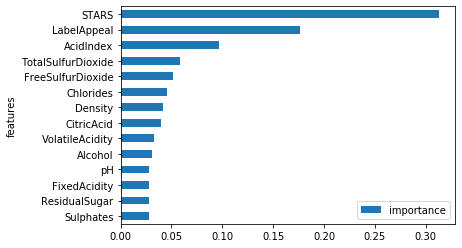

In [132]:
# Variable importance
importance = pd.DataFrame({'features': train_X.columns, 
                           'importance': rf.feature_importances_})
importance.index=importance.features
importance.sort_values(by='importance', ascending=True).plot.barh()

In [133]:
#Compare the prediction errors of the training and validation sets by examining their RMS error
RMSE_val_random= (mean_squared_error(valid_y, rf.predict(valid_X))**.5)
"RMSE validation for RandomForest: "+str(mean_squared_error(valid_y, rf.predict(valid_X))**.5)

'RMSE validation for RandomForest: 1.569504672618949'

In [134]:
RMSE_train_random=(mean_squared_error(train_y, rf.predict(train_X))**.5)
"RMSE training for RandomForest: "+str(mean_squared_error(train_y, rf.predict(train_X))**.5)

'RMSE training for RandomForest: 1.3857503258317627'

Text(0.5, 1.0, 'Validation')

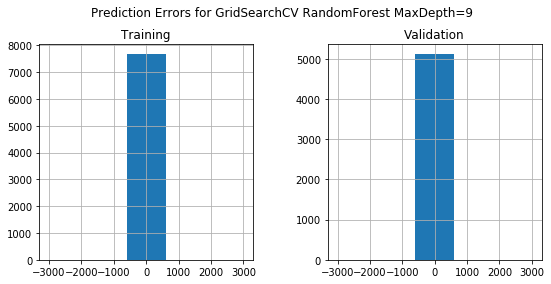

In [135]:
#plotting errors using a histogram

pred_error_train = pd.DataFrame({
    'residual':train_y - rf.predict(train_X),
    'dataset' :'Training'  
})
pred_error_valid = pd.DataFrame({
    'residual':valid_y - rf.predict(valid_X),
    'dataset' :'Validation'  
})
fig,axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(9,4)
common ={'bins':5, 'range': [-3000, 3000]}
pred_error_train.hist(ax=axes[0],**common)
pred_error_valid.hist(ax=axes[1],**common)

plt.suptitle('Prediction Errors for GridSearchCV RandomForest MaxDepth=9')
plt.subplots_adjust(bottom=0.1,top=0.85, wspace=0.35)
axes[0].set_title('Training')
axes[1].set_title('Validation')

In [136]:
## Gradient Boosting

In [137]:
#GradientBoostingRegressor
# user grid search to find optimized tree

param_grid = {
    
  #  'learning_rate':list(np.arange(0.01,0.22,.01)),  #choose initial high learning rate
    'min_samples_split': list(np.arange(2,19)),#'
    'min_samples_leaf': list(np.arange(2,6)) ,#does not reduce error
    'max_depth':list(np.arange(4,10)), #
######    'subsample': list(np.arange(0.77,0.83,.01)),
    'max_leaf_nodes': list(np.arange(5,7)), 
#    'max_features': [2,3,4,5,6,7], 
}

gridSearch = GridSearchCV(GradientBoostingRegressor(random_state=1), 
                          param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

gbm = gridSearch.best_estimator_

print("RMSE: "+str(mean_squared_error(valid_y, gbm.predict(valid_X))**.5))

Improved parameters:  {'max_depth': 4, 'max_leaf_nodes': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
RMSE: 1.5543179180586666


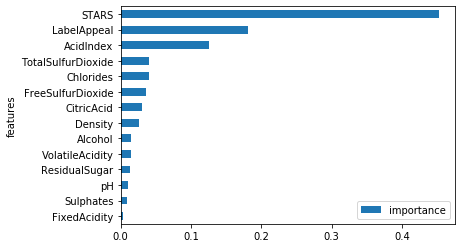

In [138]:
# Variable importance
importance = pd.DataFrame({'features': train_X.columns, 
                           'importance': gbm.feature_importances_})
importance.index=importance.features
importance.sort_values(by='importance', ascending=True).plot.barh()

In [139]:
#Compare the prediction errors of the training and validation sets by examining their RMS error
RMSE_val_gbm= (mean_squared_error(valid_y, gbm.predict(valid_X))**.5)
"RMSE validation for GradientBoost: "+str(mean_squared_error(valid_y, gbm.predict(valid_X))**.5)

'RMSE validation for GradientBoost: 1.5543179180586666'

In [140]:
RMSE_train_gbm=(mean_squared_error(train_y, gbm.predict(train_X))**.5)
"RMSE training for GradientBoost: "+str(mean_squared_error(train_y, gbm.predict(train_X))**.5)

'RMSE training for GradientBoost: 1.5065796766417423'

Text(0.5, 1.0, 'Validation')

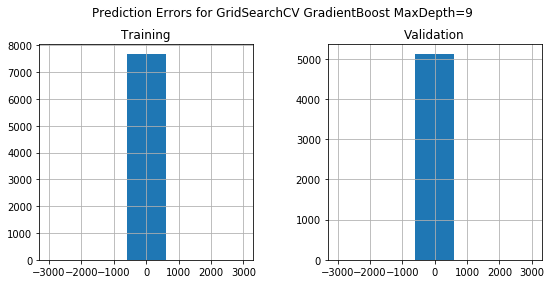

In [141]:
#plotting errors using a histogram

pred_error_train = pd.DataFrame({
    'residual':train_y - gbm.predict(train_X),
    'dataset' :'Training'  
})
pred_error_valid = pd.DataFrame({
    'residual':valid_y - gbm.predict(valid_X),
    'dataset' :'Validation'  
})
fig,axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(9,4)
common ={'bins':5, 'range': [-3000, 3000]}
pred_error_train.hist(ax=axes[0],**common)
pred_error_valid.hist(ax=axes[1],**common)

plt.suptitle('Prediction Errors for GridSearchCV GradientBoost MaxDepth=9')
plt.subplots_adjust(bottom=0.1,top=0.85, wspace=0.35)
axes[0].set_title('Training')
axes[1].set_title('Validation')

In [142]:
#Summarizing RMSE errors from decision, random and Gradient models to derive conclusion
train_error =[RMSE_train_Decision, RMSE_train_random, RMSE_train_gbm]

In [143]:
valid_error=[RMSE_val_Decision, RMSE_val_random, RMSE_val_gbm]

In [144]:
col={'Train RMSE':train_error,'Validation RMSE':valid_error}
models=['Decision Tree', 'Random Forest','Gradient Boost']
df_error=pd.DataFrame(data=col,index=models)
df_error

Train RMSE  Validation RMSE
Decision Tree     1.602348         1.654187
Random Forest     1.385750         1.569505
Gradient Boost    1.506580         1.554318

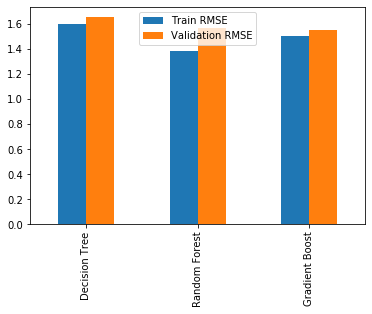

In [145]:
df_error.plot(kind='bar',fig=(15,15))

In [146]:
######### KNN Model for Target variable ########

In [147]:
# using unsclaed, no feature data i.e. df_model

In [150]:
df_model.columns

Index(['TARGET', 'FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
       'Density', 'pH', 'Sulphates', 'Alcohol', 'LabelAppeal', 'AcidIndex',
       'STARS'],
      dtype='object')

In [151]:
y=df_model['TARGET']
X = df_model.drop(['TARGET'],axis=1)

In [152]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.40, random_state=1)

print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (7677, 14) Validation set: (5118, 14)


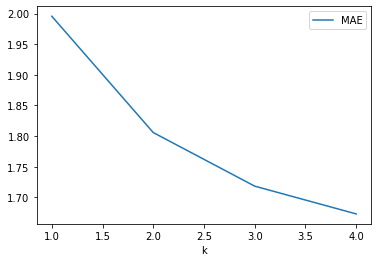

In [148]:
%matplotlib inline
results = []
for k in range(1,5):
        knn = KNeighborsRegressor(n_neighbors=k,n_jobs=-1).fit(train_X, train_y)
        results.append({
            'k': k,
            'MAE': mean_absolute_error(valid_y, knn.predict(valid_X)),
            #'RMSE': (mean_absolute_error(valid_y, knn.predict(valid_X))**0.5)
            
    })


results = pd.DataFrame(results)
results.sort_values(by='MAE')
results.index=results.k
results=results.drop('k',axis=1)
results.plot()

In [153]:
metric_list=['euclidean','manhattan','chebyshev','minkowski',]
results = []
for k in range(1,5):
    for m in metric_list:
        knn = KNeighborsRegressor(n_neighbors=k,metric=m,n_jobs=-1).fit(train_X, train_y)
        results.append({
            'k_distance': str(k)+" "+str(m),
            'MAE': mean_absolute_error(valid_y, knn.predict(valid_X)),
            'RMSE_val': (mean_squared_error(valid_y, knn.predict(valid_X))**0.5),
            'RMSE_train': (mean_squared_error(train_y, knn.predict(train_X))**0.5)
    })
results = pd.DataFrame(results)
results.sort_values(by='RMSE_val')

k_distance       MAE  RMSE_val  RMSE_train
13  4 manhattan  1.625635  2.014146    1.560316
12  4 euclidean  1.665934  2.062219    1.605975
15  4 minkowski  1.665934  2.062219    1.605975
9   3 manhattan  1.671942  2.079678    1.466663
14  4 chebyshev  1.692018  2.086497    1.625192
8   3 euclidean  1.711801  2.119252    1.511758
11  3 minkowski  1.711801  2.119252    1.511758
10  3 chebyshev  1.744041  2.154118    1.531830
5   2 manhattan  1.748730  2.199484    1.254093
4   2 euclidean  1.782923  2.237247    1.293414
7   2 minkowski  1.782923  2.237247    1.293414
6   2 chebyshev  1.819949  2.271966    1.316942
1   1 manhattan  1.906995  2.502988    0.000000
0   1 euclidean  2.001563  2.589545    0.000000
3   1 minkowski  2.001563  2.589545    0.000000
2   1 chebyshev  2.018953  2.602904    0.000000

In [170]:
RMSE_train_KNN = 1.560
RMSE_val_KNN = 2.014

In [154]:
#on training data
knn = KNeighborsRegressor(n_neighbors=4,metric='manhattan',n_jobs=-1)
knn.fit(train_X, train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                    weights='uniform')

In [155]:
#on validation data
pred_TARGET = np.round(knn.predict(valid_X))

In [156]:
pred_TARGETDF = pd.DataFrame(pred_TARGET)
pred_TARGETDF

0
0     4.0
1     4.0
2     3.0
3     3.0
4     3.0
...   ...
5113  2.0
5114  2.0
5115  4.0
5116  4.0
5117  2.0

[5118 rows x 1 columns]

In [157]:
## MLP for TARGET variable prediction ####

In [158]:
df_final=df_model

In [159]:
df_final.columns

Index(['TARGET', 'FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
       'Density', 'pH', 'Sulphates', 'Alcohol', 'LabelAppeal', 'AcidIndex',
       'STARS'],
      dtype='object')

In [160]:
predictors = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid',
              'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
              'Density', 'pH', 'Sulphates', 'Alcohol', 'LabelAppeal', 'AcidIndex','STARS']
X = pd.get_dummies(df_final[predictors], drop_first=True)
y = df_final['TARGET']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.40, random_state=1)
classes = sorted(y.unique())

In [161]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(4), activation='logistic', solver='lbfgs', random_state=1,max_iter=200)
clf.fit(train_X,train_y)
clf.predict(train_X)

# Network structure
# print('Intercepts')
# print(clf.intercepts_)

# print('Weights')
# print(clf.coefs_)

# Prediction
print(pd.concat([df_final['TARGET'],pd.DataFrame(clf.predict_proba(X), columns=classes)], axis=1))

# TC_lm = LinearRegression() clf
reg=clf.fit(train_X, train_y)

pred_train = reg.predict(train_X)
pred_valid = reg.predict(valid_X)
print("\nTraning data")
print('MAE/MAD: ',mean_absolute_error(train_y,pred_train))
print('MSE: ',mean_squared_error(train_y, pred_train))
print('RMSE: ',np.sqrt(mean_squared_error(train_y, pred_train)))
RMSE_train_MLP=np.sqrt(mean_squared_error(train_y, pred_train))

print("\nValidation data")
print('MAE/MAD: ',mean_absolute_error(valid_y,pred_valid))
print('MSE: ',mean_squared_error(valid_y, pred_valid))
RMSE_val_MLP=np.sqrt(mean_squared_error(valid_y, pred_valid))
print('RMSE: ',np.sqrt(mean_squared_error(valid_y, pred_valid)))

       TARGET         0         1         2         3         4         5  \
0           3  0.277432  0.023381  0.105755  0.263271  0.245618  0.060041   
1           3  0.088558  0.010185  0.021696  0.066587  0.333574  0.335873   
2           5  0.102427  0.011489  0.026003  0.078471  0.343373  0.308511   
3           3  0.312387  0.023641  0.138772  0.321319  0.167526  0.025086   
4           4  0.292917  0.023743  0.118017  0.286192  0.216298  0.044280   
...       ...       ...       ...       ...       ...       ...       ...   
12790       0  0.060560  0.007391  0.013636  0.043555  0.300786  0.396885   
12791       0  0.312475  0.023638  0.138893  0.321510  0.167251  0.024997   
12792       0  0.312537  0.023635  0.138978  0.321643  0.167058  0.024936   
12793       0  0.308624  0.023741  0.133953  0.313590  0.178591  0.028807   
12794       0  0.124576  0.013472  0.033314  0.098088  0.352239  0.267945   

              6         7         8  
0      0.015492  0.008408  0.000603  

In [162]:
from sklearn.ensemble import AdaBoostRegressor
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingRegressor

In [182]:
## Voting Classifier - ENSEMBLE TECHNIQUE
lr=LinearRegression()

gb = GradientBoostingRegressor(max_depth= 4, max_leaf_nodes= 5, min_samples_leaf= 5, min_samples_split= 2, random_state=1)

ada_gb=AdaBoostRegressor(GradientBoostingRegressor(max_depth= 4, max_leaf_nodes= 5, min_samples_leaf= 5, min_samples_split= 2, random_state=1), 
                         n_estimators=10, random_state=1)

rf = RandomForestRegressor(max_depth= 9,max_features=5, min_samples_leaf= 5, min_samples_split= 2, random_state=1)
knn = KNeighborsRegressor(n_neighbors=4,metric='manhattan',n_jobs=-1)

#dc=DecisionTreeRegressor(max_depth=6, max_features=7, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=10, random_state=1)

clf = VotingRegressor([ ('lr',lr),
                        ('knn',knn),
                        ('gb',gb),
                        ('ada_gb',ada_gb),
                        ('rf',rf)],
                         n_jobs=-1)
clf.fit(train_X, train_y).predict(train_X)

print(clf)

#cm = confusion_matrix(valid_y,clf.predict(valid_X)).ravel()
#print(cm)
RMSE_train_vote=(mean_squared_error(train_y, clf.predict(train_X))**.5)
print("RMSE training: "+str(mean_squared_error(train_y, clf.predict(train_X))**.5))

#print("RMSE: "+str(mean_squared_error(valid_y, clf.predict(valid_X))**.5))

#tn=cm[0]
#fp=cm[1]
#fn=cm[2]
#tp=cm[3]
#true_positive_rate = tp / (tp + fn)
#true_positive_rate 



VotingRegressor(estimators=[('lr',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False)),
                            ('knn',
                             KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='manhattan',
                                                 metric_params=None, n_jobs=-1,
                                                 n_neighbors=4, p=2,
                                                 weights='uniform')),
                            ('gb',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       lear...
                             RandomForestRegressor(bootstrap=True,
          

In [183]:
## Voting Classifier - ENSEMBLE TECHNIQUE
lr=LinearRegression()

gb = GradientBoostingRegressor(max_depth= 4, max_leaf_nodes= 5, min_samples_leaf= 5, min_samples_split= 2, random_state=1)

ada_gb=AdaBoostRegressor(GradientBoostingRegressor(max_depth= 4, max_leaf_nodes= 5, min_samples_leaf= 5, min_samples_split= 2, random_state=1), 
                         n_estimators=10, random_state=1)
knn = KNeighborsRegressor(n_neighbors=4,metric='manhattan',n_jobs=-1)

rf = RandomForestRegressor(max_depth= 9,max_features=5, min_samples_leaf= 5, min_samples_split= 2, random_state=1)

#dc=DecisionTreeRegressor(max_depth=6, max_features=7, min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=10, random_state=1)

clf = VotingRegressor([ ('lr',lr),
                        ('knn',knn),
                        ('gb',gb),
                        ('ada_gb',ada_gb),
                        ('rf',rf)],
                         n_jobs=-1)
clf.fit(valid_X, valid_y).predict(valid_X)

print(clf)

#cm = confusion_matrix(valid_y,clf.predict(valid_X)).ravel()
#print(cm)
#print("RMSE train: "+str(mean_squared_error(train_y, clf.predict(train_X))**.5))
RMSE_val_Vote = (mean_squared_error(valid_y, clf.predict(valid_X))**.5)
print("RMSE validation: "+str(mean_squared_error(valid_y, clf.predict(valid_X))**.5))

#tn=cm[0]
#fp=cm[1]
#fn=cm[2]
#tp=cm[3]
#true_positive_rate = tp / (tp + fn)
#true_positive_rate 



VotingRegressor(estimators=[('lr',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False)),
                            ('knn',
                             KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='manhattan',
                                                 metric_params=None, n_jobs=-1,
                                                 n_neighbors=4, p=2,
                                                 weights='uniform')),
                            ('gb',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       lear...
                             RandomForestRegressor(bootstrap=True,
          

# Summarizing results from all models ###

In [184]:
train_error =[train_RMSE_woFE,trainRMSE_lin,trainRMSE_Lasso,trainRMSE_LassoCV,trainRMSE_Ridge,trainRMSE_RidgeCV, train_RMSE_wFE_scaled,trainRMSE_lin_sc,trainRMSE_Lasso_sc,trainRMSE_LassoCV_sc,trainRMSE_Ridge_sc,trainRMSE_RidgeCV_sc, RMSE_train_Decision, RMSE_train_random, RMSE_train_gbm, RMSE_train_KNN, RMSE_train_MLP, RMSE_train_vote]

In [185]:
valid_error=[valid_RMSE_woFE,validRMSE_lin,validRMSE_Lasso,validRMSE_LassoCV,validRMSE_Ridge,validRMSE_RidgeCV, valid_RMSE_wFE_scaled,validRMSE_lin_sc,validRMSE_Lasso_sc,validRMSE_LassoCV_sc,validRMSE_Ridge_sc,validRMSE_RidgeCV_sc, RMSE_val_Decision, RMSE_val_random, RMSE_val_gbm, RMSE_val_KNN, RMSE_val_MLP, RMSE_val_Vote]

In [186]:
col={'Train RMSE':train_error,'Validation RMSE':valid_error}
models=['Linear Reg without FE','Linear Reg with FE','Lasso','Lasso CV','Ridge','RidgeCV', 'Linear Reg w FE exh scaled','Linear Regression w FE scaled','Lasso scaled','Lasso CV scaled','Ridge scaled','RidgeCV scaled', 'Decision Tree', 'Random Forest','Gradient Boost', 'KNN', 'MLP','VotingRegressor']
df_error=pd.DataFrame(data=col,index=models)
df_error.sort_values(by='Validation RMSE')
#df_error

Train RMSE  Validation RMSE
VotingRegressor                  1.449496         1.420089
Gradient Boost                   1.506580         1.554318
Random Forest                    1.385750         1.569505
Linear Reg without FE            1.618000         1.604000
Linear Reg with FE               1.618100         1.605700
Lasso CV                         1.618100         1.605700
RidgeCV                          1.619800         1.608900
Decision Tree                    1.602348         1.654187
Linear Reg w FE exh scaled       1.676000         1.659000
Linear Regression w FE scaled    1.675800         1.660900
Lasso CV scaled                  1.675800         1.660900
RidgeCV scaled                   1.677700         1.664300
Ridge                            1.678500         1.674600
Ridge scaled                     1.736200         1.730400
Lasso                            1.924400         1.929200
Lasso scaled                     1.924400         1.929200
KNN                              1.560000         2.014000
MLP                              2.061008         2.031166

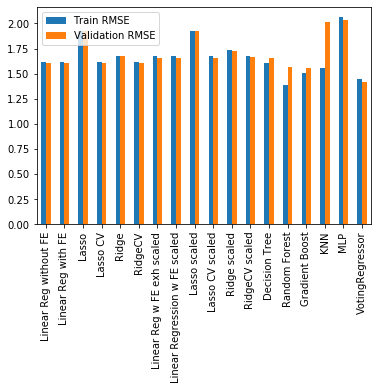

In [188]:
df_error.plot(kind='bar',fig=(15,15))